In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

# understat import for understat api
import asyncio
import json
import aiohttp
from understat import Understat
year = ['2014','2015','2016','2017','2018','2019','2020']

import sys,importlib
# importlib.reload(sys.modules['function'])
from function import *

modèle regression logistique 
* résultat :
    * européen
    * non-européen

* Critère défense : 
    * valeur
    * taille
    * vitesse
    * expérience
    * (poid)

# Projet 8 - Arsenal, européen ?

Préparation des données

In [4]:
ligue_df_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_table("La_liga", i)
            ligue_df = pd.DataFrame(data=table)
            ligue_df['year'] = i
            ligue_df['Rank'] = ligue_df.index
            ligue_df_all.append(ligue_df)
        df = pd.concat(ligue_df_all)
        return df
loop = asyncio.get_event_loop()
import nest_asyncio
nest_asyncio.apply()
df_ligue = loop.run_until_complete(main())
df_ligue.columns = df_ligue.iloc[0]
df_ligue = df_ligue[1:] 
df_ligue.rename(columns={'2014':'Years',0:'Rank'},inplace=True)
df_ligue = df_ligue[['Rank','Team','M','W','D','L','G','GA','PTS','xG','xGA','xPTS','Years']]

In [5]:
df_ligue['Team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo', 'Malaga',
       'Espanyol', 'Rayo Vallecano', 'Real Sociedad', 'Elche', 'Getafe',
       'Levante', 'Eibar', 'Deportivo La Coruna', 'Granada', 'Almeria',
       'Cordoba', 'Team', 'Real Betis', 'Las Palmas', 'Sporting Gijon',
       'Alaves', 'Leganes', 'Osasuna', 'Girona', 'Real Valladolid',
       'SD Huesca', 'Mallorca', 'Cadiz'], dtype=object)

In [165]:
euro_crew = ['fc-barcelona', 'real-madrid', 'atletico-madrid', 'fc-valencia','fc-sevilla', 'fc-villarreal', 'athletic-bilbao', 'celta-vigo','fc-malaga','espanyol-barcelona',
             'rayo-vallecano','real-sociedad-san-sebastian','fc-elche','fc-getafe','ud-levante','deportivo-la-coruna','fc-granada','ud-almeria','fc-cordoba','real-betis-sevilla',
             'ud-las-palmas','sporting-gijon','deportivo-alaves','cd-leganes','ca-osasuna','fc-girona','real-valladolid','sd-huesca','rcd-mallorca','fc-cadiz','eibar']
num = ['131','418','13','1049','368','1050','621','940','1084','714','367','681','1531','3709','3368','897','16795','3302','993','150','472','2448','1108','1244','331','12321','366','5358','237','2687','1533']
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [166]:
for eq,num_eq in zip(euro_crew,num):
    print(eq,num_eq)

fc-barcelona 131
real-madrid 418
atletico-madrid 13
fc-valencia 1049
fc-sevilla 368
fc-villarreal 1050
athletic-bilbao 621
celta-vigo 940
fc-malaga 1084
espanyol-barcelona 714
rayo-vallecano 367
real-sociedad-san-sebastian 681
fc-elche 1531
fc-getafe 3709
ud-levante 3368
deportivo-la-coruna 897
fc-granada 16795
ud-almeria 3302
fc-cordoba 993
real-betis-sevilla 150
ud-las-palmas 472
sporting-gijon 2448
deportivo-alaves 1108
cd-leganes 1244
ca-osasuna 331
fc-girona 12321
real-valladolid 366
sd-huesca 5358
rcd-mallorca 237
fc-cadiz 2687
eibar 1533


In [167]:
header_crew = ['Position', 'Valeur maximum']
df_crew = []

for eq,num_eq in zip(euro_crew,num):
    for k in year:
        try:
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            
        except TimeoutError:
            print('k')
            print(eq,k)
            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            value = soup.find('div',{'class':'large-8 columns'}).div.find('div',{'class':'responsive-table'}).table.tbody.find_all('tr')
            list_attribute = []
            list_money_money = []
            table_list = []
            for i in value:
                try:
                    money = i.find('td',{'class':'rechts hauptlink'}).text
                    if 'K' in money:
                        list_money_money.append(float(money.split(' ')[0])/1000)
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)
                    elif 'mio' in money:
                        list_money_money.append(float(money.split(' ')[0].replace(',','.')))
                        text = i.find('td',{'class':'posrela'}).table.find_all('tr')[1].text
                        list_attribute.append(text)

                except AttributeError:
                    continue

            table_list.append(list_attribute)
            table_list.append(list_money_money)
            value_crew = pd.DataFrame(data=table_list,index=header_crew)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            value_crew = value_crew.T
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            value_crew = value_crew.reset_index()

            #print(value_crew)
            value_crew_max = value_crew.sort_values(by='Valeur maximum',ascending=False)
            gardien = value_crew_max[value_crew_max['Position'] == 'Gardien de but'].iloc[0:1]
            defenseur = value_crew_max[(value_crew_max['Position'] == 'Défenseur central')|(value_crew_max['Position'] == 'Arrière gauche')|(value_crew_max['Position'] == 'Arrière droit')].iloc[0:1]
            milieu = value_crew_max[(value_crew_max['Position'] == 'Milieu défensif')|(value_crew_max['Position'] == 'Milieu central')|(value_crew_max['Position'] == 'Milieu offensif')].iloc[0:1]
            attaquant = value_crew_max[(value_crew_max['Position'] == 'Ailier droit')|(value_crew_max['Position'] == 'Ailier gauche')|(value_crew_max['Position'] == 'Avant-centre')].iloc[0:1]
            total = value_crew_max.iloc[0:1]

            gardien['Position'] = 'Gardien'
            defenseur['Position'] = 'Défense'
            milieu['Position'] = 'Milieu'
            attaquant['Position'] = 'Attaquant'
            total['Position'] = 'Total'
            value_crew_all = pd.concat([gardien,defenseur,milieu,attaquant,total])
            df_crew.append(value_crew_all)
            continue
df_value_max = pd.concat(df_crew)

fc-barcelona 2014


<ipython-input-167-533fd743d504>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Position'] = 'Total'


fc-barcelona 2015
fc-barcelona 2016
fc-barcelona 2017
fc-barcelona 2018
fc-barcelona 2019
fc-barcelona 2020
real-madrid 2014
real-madrid 2015
real-madrid 2016
real-madrid 2017
real-madrid 2018
real-madrid 2019
real-madrid 2020
atletico-madrid 2014
atletico-madrid 2015
atletico-madrid 2016
atletico-madrid 2017
atletico-madrid 2018
atletico-madrid 2019
atletico-madrid 2020
fc-valencia 2014
fc-valencia 2015
fc-valencia 2016
fc-valencia 2017
fc-valencia 2018
fc-valencia 2019
fc-valencia 2020
fc-sevilla 2014
fc-sevilla 2015
fc-sevilla 2016
fc-sevilla 2017
fc-sevilla 2018
fc-sevilla 2019
fc-sevilla 2020
fc-villarreal 2014
fc-villarreal 2015
fc-villarreal 2016
fc-villarreal 2017
fc-villarreal 2018
fc-villarreal 2019
fc-villarreal 2020
athletic-bilbao 2014
athletic-bilbao 2015
athletic-bilbao 2016
athletic-bilbao 2017
athletic-bilbao 2018
athletic-bilbao 2019
athletic-bilbao 2020
celta-vigo 2014
celta-vigo 2015
celta-vigo 2016
celta-vigo 2017
celta-vigo 2018
celta-vigo 2019
celta-vigo 2020
fc-

In [168]:
df_crew = []
header_crew = ['Positions', 'Âge', 'Valeur marchande', 'Valeur marchande moyenne']
for eq,num_eq in zip(euro_crew,num):
    print(eq)
    if eq == 'thonon-evian-grand-geneve-fc':
        for k in year[:3]:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
    else:
        for k in year:

            page = "https://www.transfermarkt.fr/"+eq+"/kader/verein/"+num_eq+"/plus/0/galerie/0?saison_id="+k
            pageTree = requests.get(page, headers=headers)
            soup = BeautifulSoup(pageTree.content, 'html.parser')
            body = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tbody.find_all('td')
            foot = soup.html.find('div',{'class':'large-4 columns'}).find('div',{'class':'box'}).table.tfoot.find_all('tr')
            x = 0
            table_list = [header_crew]
            body_list = []
            for g in body:

                body_list.append(g.text)
                x = x + 1
                if x == 5:
                    table_list.append(body_list[1:])
                    body_list = []
                    x = 0

            for h in foot: 
                foot_list = []
                for gk2 in h.find_all('td'):
                    foot_list.append(gk2.text)
                table_list.append(foot_list)

            value_crew = pd.DataFrame(data=table_list)
            value_crew.columns = value_crew.iloc[0]
            value_crew = value_crew.iloc[1:]
            #print(value_crew,k)
            value_crew['Years'] = k
            value_crew['Crew'] = eq
            df_crew.append(value_crew)
#print(df_crew)
df_euro_all = pd.concat(df_crew)

fc-barcelona
real-madrid
atletico-madrid
fc-valencia
fc-sevilla
fc-villarreal
athletic-bilbao
celta-vigo
fc-malaga
espanyol-barcelona
rayo-vallecano
real-sociedad-san-sebastian
fc-elche
fc-getafe
ud-levante
deportivo-la-coruna
fc-granada
ud-almeria
fc-cordoba
real-betis-sevilla
ud-las-palmas
sporting-gijon
deportivo-alaves
cd-leganes
ca-osasuna
fc-girona
real-valladolid
sd-huesca
rcd-mallorca
fc-cadiz
eibar


In [169]:
df_euro_all

,Positions,Âge,Valeur marchande,Valeur marchande moyenne,Years,Crew
1,Gardien,"26,00","28,50 mio. €","9,50 mio. €",2014,fc-barcelona
2,Défense,"25,90","124,20 mio. €","12,42 mio. €",2014,fc-barcelona
3,Milieu de terrain,"23,91","151,10 mio. €","13,74 mio. €",2014,fc-barcelona
4,Attaquant,"22,29","300,00 mio. €","42,86 mio. €",2014,fc-barcelona
5,Total:,"24,39","603,80 mio. €","19,48 mio. €",2014,fc-barcelona
...,...,...,...,...,...,...
1,Gardien,"23,50","9,10 mio. €","2,28 mio. €",2020,eibar
2,Défense,"26,08","22,40 mio. €","1,72 mio. €",2020,eibar
3,Milieu de terrain,"26,00","9,80 mio. €","1,40 mio. €",2020,eibar
4,Attaquant,"27,10","42,10 mio. €","4,21 mio. €",2020,eibar


In [170]:
df_euro_all.rename(columns={'Valeur marchande':'Valeur marchande (millions)','Valeur marchande moyenne':'Valeur marchande moyenne (millions)'},inplace=True)

In [171]:
# df_euro_all[['Position', 'Valeur maximum', 'Valeur marchande (millions)','Valeur marchande moyenne (millions)', 'Years', 'Crew']]

In [172]:
df_euro_all = df_euro_all[df_euro_all['Valeur marchande (millions)'] != '-']

In [173]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande moyenne (millions)']]

<ipython-input-173-9757b94fd2ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]
<ipython-input-173-9757b94fd2ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande moyenne (millions)']]


In [174]:
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        print(float(i.replace(' mrd. €','')))

1.1
1.2
1.03
1.0


In [175]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]

<ipython-input-175-4e5fdd517078>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro_all['Valeur marchande (millions)']]


In [176]:
df_euro_all['Valeur marchande (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande (millions)']]
df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande moyenne (millions)']]

<ipython-input-176-fd83e03bef9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande (millions)']]
<ipython-input-176-fd83e03bef9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande moyenne (millions)'] = [i.replace(' mio. €','') for i in df_euro_all['Valeur marchande moyenne (millions)']]


In [177]:
list_vald = []
for i in df_euro_all['Valeur marchande (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande (millions)'] = list_vald

<ipython-input-177-3bd0f442ad11>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande (millions)'] = list_vald


In [178]:
list_vald = []
for i in df_euro_all['Valeur marchande moyenne (millions)']:
    if ' mrd. €' in i:
        list_vald.append(float(i.replace(' mrd. €',''))*1000)
    elif ' K €' in i:
        list_vald.append(float(i.replace(' K €',''))/1000)        
    else:
        list_vald.append(float(i))
    
df_euro_all['Valeur marchande moyenne (millions)'] = list_vald

<ipython-input-178-d43ab56a6da6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Valeur marchande moyenne (millions)'] = list_vald


In [179]:
df_euro_all['Positions'] = [i.replace(':','') for i in df_euro_all['Positions']]

<ipython-input-179-91e86311181e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Positions'] = [i.replace(':','') for i in df_euro_all['Positions']]


In [180]:
df_euro_all['Crew'] = [i.replace('-',' ') for i in df_euro_all['Crew']]
df_euro_all['Crew'] = [i.replace('fc','') for i in df_euro_all['Crew']]

<ipython-input-180-a5f5e3d9d0c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Crew'] = [i.replace('-',' ') for i in df_euro_all['Crew']]
<ipython-input-180-a5f5e3d9d0c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_euro_all['Crew'] = [i.replace('fc','') for i in df_euro_all['Crew']]


In [181]:
df_ligue = df_ligue[df_ligue['Team'] != 'Team']

In [182]:
df_ligue.to_csv('ligue_Liga.csv',index=False)
df_value_max.to_csv('all_value_max_Liga.csv',index=False)

In [183]:
df_euro_all.to_csv('all_value_euro_Liga.csv',index=False)

In [184]:
ligue_player_all = []
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        for i in year:
            table = await understat.get_league_players("La_liga", i)
            ligue_player = pd.DataFrame(data=table)
            ligue_player['year'] = i
            ligue_player_all.append(ligue_player)
        df = pd.concat(ligue_player_all)
        return df
loop = asyncio.get_event_loop()

In [185]:
import nest_asyncio
nest_asyncio.apply()
df_ligue_player = loop.run_until_complete(main())

In [186]:
df_ligue_player.head()

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,2371,Cristiano Ronaldo,35,3103,48,39.30876067932695,16,13.600642347708344,225,76,5,1,F M,Real Madrid,38,30.389685845933855,43.60801999177784,7.5202372539788485,2014
1,2097,Lionel Messi,38,3374,43,35.89176357910037,18,17.61195552162826,187,95,4,0,F S,Barcelona,38,31.432097773998976,54.75360991060734,19.75672373920679,2014
2,2099,Neymar,33,2573,22,22.721617586910725,7,8.261543160304427,95,52,6,0,F S,Barcelona,21,21.978339917957783,36.88822028413415,11.678407426923513,2014
3,2270,Antoine Griezmann,37,2490,22,14.709661848843098,1,2.60772124864161,78,23,6,0,F M S,Atletico Madrid,22,14.709661848843098,18.479452416300774,4.551564212888479,2014
4,1125,Carlos Bacca,37,2581,20,19.279243662953377,6,4.728216256946325,69,31,4,0,F S,Sevilla,14,13.33366459980607,16.086337637156248,2.6682413946837187,2014


In [187]:
# print(df_ligue_player.dtypes)
# df_ligue_player.columns

In [188]:
df_ligue_player['xG'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xG']]
df_ligue_player['xA'] = [np.around(float(i),decimals=4) for i in df_ligue_player['xA']]


In [189]:
column = ['games', 'time', 'goals',  'assists', 
       'shots', 'key_passes', 'yellow_cards', 'red_cards','npg', 'year']
for i in column:
    df_ligue_player[i] = df_ligue_player[i].astype(int)

In [190]:
column = ['xG','xA','npxG', 'xGChain', 'xGBuildup']
for i in column:
    df_ligue_player[i] = [np.around(float(i),decimals=4) for i in df_ligue_player[i]]
    

In [191]:
# df_ligue_player[df_ligue_player['team_title'] == 'Montpellier']

In [192]:
df_ligue_player.to_csv('all_player_Liga.csv',index=False)

# Analyse

In [395]:
df_player = pd.read_csv('all_player_Liga.csv',sep=',')
df_euro = pd.read_csv('all_value_euro_Liga.csv',sep=',')
value_max = pd.read_csv('all_value_max_Liga.csv',sep=',')

In [194]:
ligue = pd.read_csv('ligue_Liga.csv',sep=',')

In [195]:
# column_2019 = ligue.columns
# psg_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i])
#     else:
#         psg_2019.append(ligue[(ligue['Years'] == 2019)&((ligue['Team'] == 'Paris Saint Germain')|(ligue['Team'] == 'Strasbourg'))][i]*1.4074074074074074)

# psg_2019_df = pd.DataFrame(data=psg_2019)
# psg_2019_df = psg_2019_df.T

In [196]:
# euro_2019 = []
# for i in column_2019:
#     if (i == 'Rank')|(i == 'Team')|(i == 'Years'):
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i],ligue[ligue['Years'] == 2019].iloc[11:][i]]))
#     else:
#         euro_2019.append(pd.concat([ligue[ligue['Years'] == 2019].iloc[1:10][i]*1.3571428571428572,ligue[ligue['Years'] == 2019].iloc[11:][i]*1.3571428571428572]))
# euro_2019_df = pd.DataFrame(data=euro_2019)
# euro_2019_df = euro_2019_df.T

In [197]:
# euro_ligue_without = ligue[ligue['Years'] != 2019]
ligue_corr = ligue
# ligue_corr = ligue_corr.sort_index()

In [198]:
list_xG = []
for i,a in zip(list(ligue['xG']),list(ligue['G'])):
    #print(i,a)
    list_xG.append(np.around(int(a)/int(i),decimals=3))

list_xGA = []
for e,h in zip(list(ligue['xGA']),list(ligue['GA'])):
    list_xGA.append(np.around(int(h)/int(e),decimals=3))

list_xPTS = []
for e,h in zip(list(ligue['xPTS']),list(ligue['PTS'])):
    list_xPTS.append(np.around(int(h)/int(e),decimals=3))

ligue_corr['xG coef'] = list_xG
ligue_corr['xGA coef'] = list_xGA
ligue_corr['xPTS coef'] = list_xPTS

In [199]:
ligue_corr['M'] = [np.around(i,decimals=0) for i in ligue_corr['M']]
ligue_corr['W'] = [np.around(i,decimals=0) for i in ligue_corr['W']]
ligue_corr['D'] = [np.around(i,decimals=0) for i in ligue_corr['D']]
ligue_corr['L'] = [np.around(i,decimals=0) for i in ligue_corr['L']]
ligue_corr['G'] = [np.around(i,decimals=3) for i in ligue_corr['G']]
ligue_corr['GA'] = [np.around(i,decimals=3) for i in ligue_corr['GA']]
ligue_corr['PTS'] = [np.around(i,decimals=0) for i in ligue_corr['PTS']]
ligue_corr['xG'] = [np.around(i,decimals=3) for i in ligue_corr['xG']]
ligue_corr['xGA'] = [np.around(i,decimals=3) for i in ligue_corr['xGA']]
ligue_corr['xPTS'] = [np.around(i,decimals=3) for i in ligue_corr['xPTS']]
ligue_corr['xG coef'] = [np.around(i,decimals=3) for i in ligue_corr['xG coef']]
ligue_corr['xGA coef'] = [np.around(i,decimals=3) for i in ligue_corr['xGA coef']]

In [200]:
ligue_corr.to_csv('ligue_corrected.csv',index=False)

In [201]:
ligue_corr = pd.read_csv('ligue_corrected.csv',sep=',')

In [202]:
ligue_corr[ligue_corr['Years'] == 2014]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
0,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000
1,2,Real Madrid,38,30,2,6,118,38,92,95.77,42.61,81.75,2014,1.242,0.905,1.136
2,3,Atletico Madrid,38,23,9,6,67,29,78,57.05,29.07,73.14,2014,1.175,1.000,1.068
3,4,Valencia,38,22,11,5,70,32,77,55.06,39.39,63.71,2014,1.273,0.821,1.222
4,5,Sevilla,38,23,7,8,71,45,76,69.53,47.86,67.39,2014,1.029,0.957,1.134
5,6,Villarreal,38,16,12,10,48,37,60,56.77,40.70,62.74,2014,0.857,0.925,0.968
6,7,Athletic Club,38,15,10,13,42,41,55,45.54,44.11,53.36,2014,0.933,0.932,1.038
7,8,Celta Vigo,38,13,12,13,47,44,51,58.89,51.78,55.05,2014,0.810,0.863,0.927
8,9,Malaga,38,14,8,16,42,48,50,46.22,54.13,48.51,2014,0.913,0.889,1.042
9,10,Espanyol,38,13,10,15,47,51,49,43.98,48.30,50.38,2014,1.093,1.062,0.980


In [203]:
ars = ligue_corr[ligue_corr['Team'] == 'Villarreal']

In [204]:
column = ['M', 'W', 'D', 'L', 'G', 'GA', 'PTS','Years']
for i in column:
    ars[i] = ars[i].astype(int)
    ligue_corr[i] = ligue_corr[i].astype(int)

<ipython-input-204-d197d87a3f85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ars[i] = ars[i].astype(int)


In [205]:
ligue_corr['Team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo', 'Malaga',
       'Espanyol', 'Rayo Vallecano', 'Real Sociedad', 'Elche', 'Getafe',
       'Levante', 'Eibar', 'Deportivo La Coruna', 'Granada', 'Almeria',
       'Cordoba', 'Real Betis', 'Las Palmas', 'Sporting Gijon', 'Alaves',
       'Leganes', 'Osasuna', 'Girona', 'Real Valladolid', 'SD Huesca',
       'Mallorca', 'Cadiz'], dtype=object)

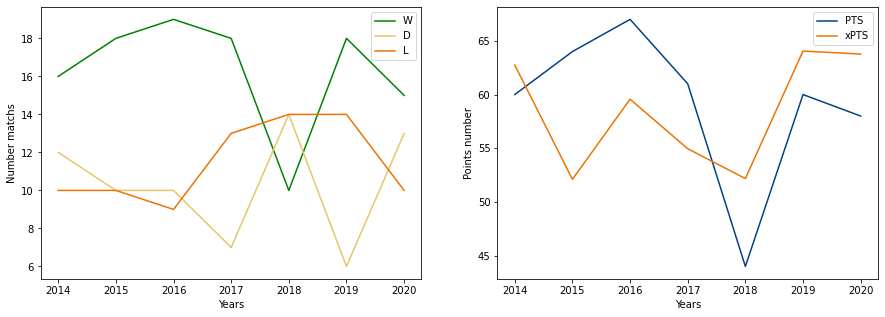

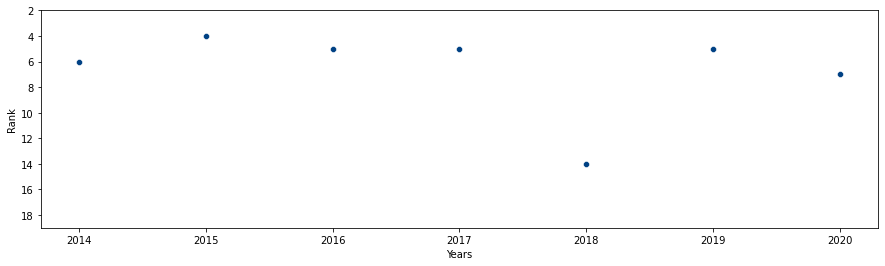

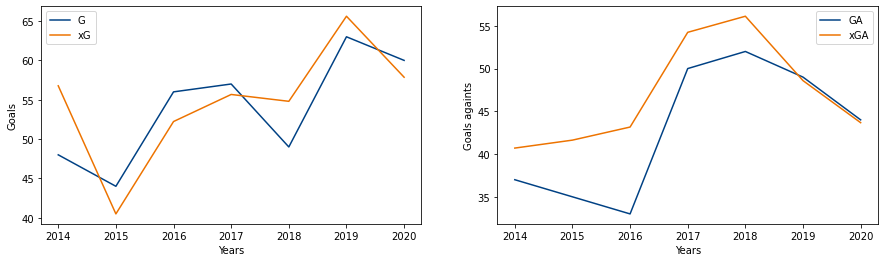

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[15,5])
# plt.plot(list(ars['Years']), list(ars['L']), label='L')
plt.subplot(121)
sns.lineplot(x="Years",y='W',data=ars,color='green',label='W')
sns.lineplot(x="Years",y='D',data=ars,color='#e9c46a',label='D')
sns.lineplot(x="Years",y='L',data=ars,color='#ED7300',label='L')
plt.ylabel('Number matchs')
plt.subplot(122)
sns.lineplot(x="Years",y='PTS',data=ars,color='#004184',label='PTS')
sns.lineplot(x="Years",y='xPTS',data=ars,color='#ED7300',label='xPTS')
plt.ylabel('Points number')
plt.show()
plt.figure(figsize=[15,4])
sns.scatterplot(x="Years",y='Rank',data=ars,color='#004184')
plt.ylim(19,2)
# for index,row in zip(range(0,len(ars.index)),ars['Rank']):
#     print(row)
#     plt.text(index*0.1,,str(row), color='black', ha="center")
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="Years",y='G',data=ars,color='#004184',label='G')
sns.lineplot(x="Years",y='xG',data=ars,color='#ED7300',label='xG')
plt.ylabel('Goals')
plt.subplot(122)
sns.lineplot(x="Years",y='GA',data=ars,color='#004184',label='GA')
sns.lineplot(x="Years",y='xGA',data=ars,color='#ED7300',label='xGA')
plt.ylabel('Goals againts')
plt.show()

### Player

In [358]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [359]:
euro_ligue_corr['Team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo',
       'Real Sociedad', 'Real Betis', 'Getafe'], dtype=object)

In [360]:
df_ars_players_stat = []
for i in year:
    goals = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['goals'])    
    expect_goals = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['xG'])
    np = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npg'])    
    npG = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))].sort_values(by='goals',ascending=False).iloc[0:3]['npxG'])
    red_card = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))]['red_cards'])
    yellow_card = sum(df_player[(df_player['team_title'] == 'Villarreal')&(df_player['year'] == int(i))]['yellow_cards'])
    df_ars_players_stat.append(pd.DataFrame({'year':[i],'goals':[goals],'expect_goals':[expect_goals],'goals without penalty':[np],'expect goals without penalty':[npG],'red card':[red_card],'yellow card':[yellow_card]}))
stat_ars = pd.concat(df_ars_players_stat)

In [361]:
import numpy as np

In [362]:
list_goal_pourcent = []
for i,e in zip(stat_ars['goals'],ars['G']):
    #print(e,i)
    list_goal_pourcent.append(np.around(((i/e)*100),decimals=3))

In [363]:
stat_ars['Pourcent goal'] = list_goal_pourcent

A faire :

    - pourcentage de goals des 3 meilleurs buteurs sur l'ensemble des buts
    - red/yellow card 
 

In [364]:
stat_ars

,year,goals,expect_goals,goals without penalty,expect goals without penalty,red card,yellow card,Pourcent goal
0,2014,25,26.3283,24,25.5850,2,85,52.083
0,2015,22,19.8889,19,17.6591,4,96,50.000
0,2016,28,20.9799,27,20.2366,4,80,50.000
0,2017,30,25.1756,28,23.6892,6,104,52.632
0,2018,24,26.5152,23,24.2853,3,111,48.980
0,2019,35,32.0154,26,24.5826,0,78,55.556
0,2020,34,32.2518,23,23.3326,2,64,56.667


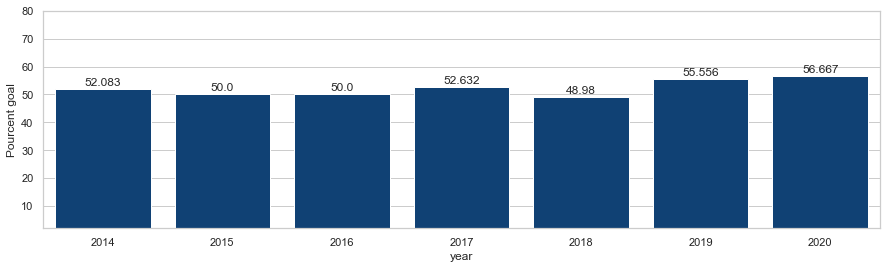

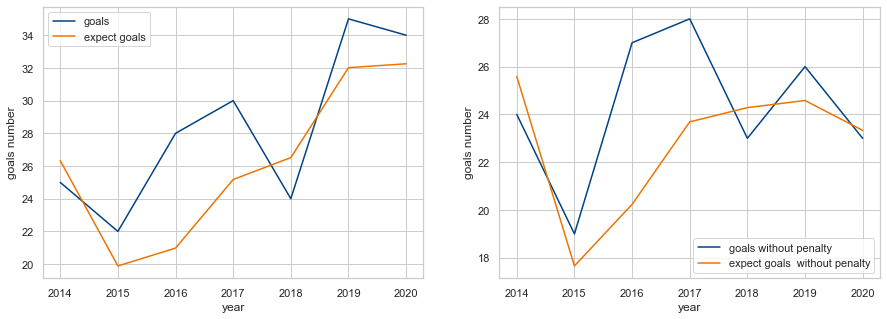

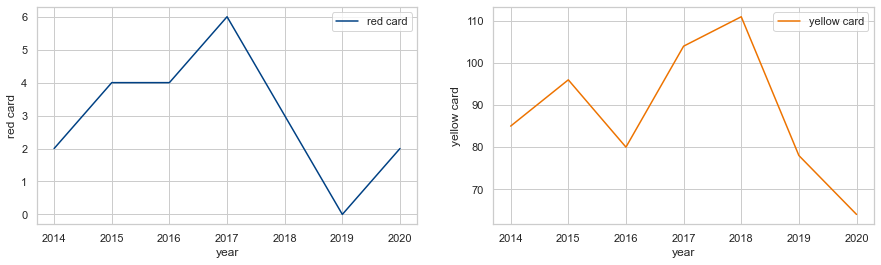

In [365]:
plt.figure(figsize=[15,4])
sns.barplot(x="year",y='Pourcent goal',data=stat_ars,color='#004184')
rects = stat_ars["year"]
labels = stat_ars['Pourcent goal']
for rect, label in zip(range(0,(len(rects))), labels):
    height = label
    plt.text(
        rect, height + 0.5, label, ha="center", va="bottom"
    )
plt.ylim(2,80)
plt.show()
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.lineplot(x="year",y='goals',data=stat_ars,color='#004184',label='goals')
sns.lineplot(x="year",y='expect_goals',data=stat_ars,color='#ED7300',label='expect goals')
plt.ylabel('goals number')
plt.subplot(122)
sns.lineplot(x="year",y='goals without penalty',data=stat_ars,color='#004184',label='goals without penalty')
sns.lineplot(x="year",y='expect goals without penalty',data=stat_ars,color='#ED7300',label='expect goals  without penalty')
plt.ylabel('goals number')
plt.show()
plt.figure(figsize=[15,4])
plt.subplot(121)
sns.lineplot(x="year",y='red card',data=stat_ars,color='#004184',label='red card')
plt.subplot(122)
sns.lineplot(x="year",y='yellow card',data=stat_ars,color='#ED7300',label='yellow card')
plt.show()

# Concurrents

In [366]:
ars

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef
5,6,Villarreal,38,16,12,10,48,37,60,56.77,40.70,62.74,2014,0.857,0.925,0.968
23,4,Villarreal,38,18,10,10,44,35,64,40.49,41.63,52.11,2015,1.100,0.854,1.231
44,5,Villarreal,38,19,10,9,56,33,67,52.23,43.16,59.57,2016,1.077,0.767,1.136
64,5,Villarreal,38,18,7,13,57,50,61,55.67,54.24,54.96,2017,1.036,0.926,1.130
93,14,Villarreal,38,10,14,14,49,52,44,54.80,56.12,52.18,2018,0.907,0.929,0.846
104,5,Villarreal,38,18,6,14,63,49,60,65.61,48.59,64.05,2019,0.969,1.021,0.938
126,7,Villarreal,38,15,13,10,60,44,58,57.86,43.67,63.77,2020,1.053,1.023,0.921


In [367]:
euro_ligue_corr = ligue_corr[ligue_corr['Rank'] < 7]

In [368]:
# ligue_corr[ligue_corr['Years'] == 2019]

In [369]:
ars_point= ars.set_index('Years')[['PTS','Rank']].T

In [370]:
list(ars_point.values[0])

[60, 64, 67, 61, 44, 60, 58]

In [371]:
# euro_ligue_corr

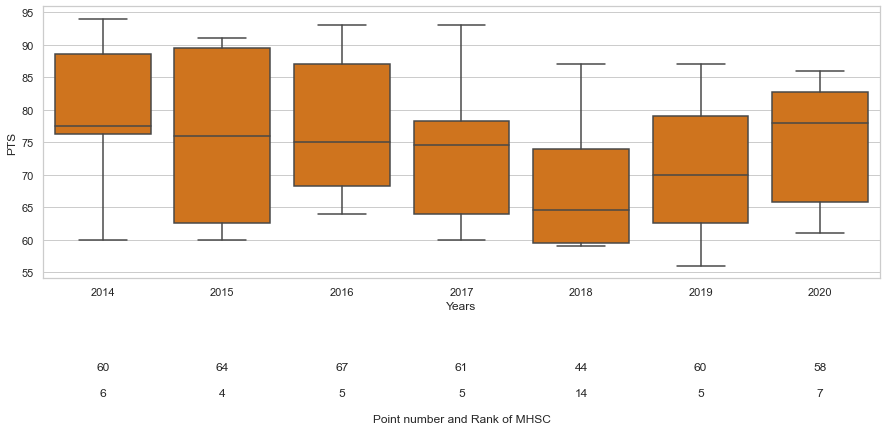

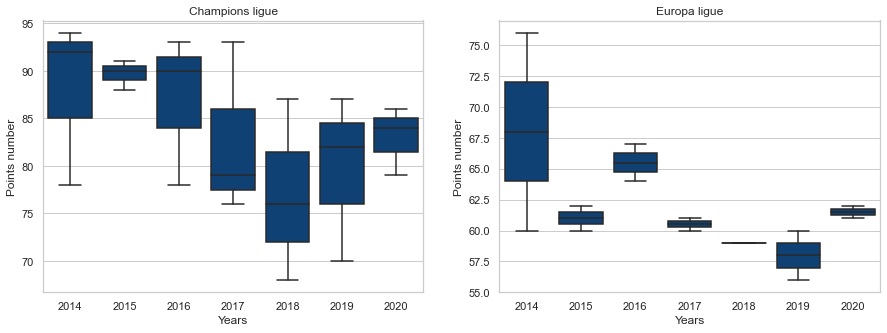

In [372]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='PTS',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_point.values[0])
labels_rank = list(ars_point.values[1])
plt.text(3,32,'Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 40, label1,horizontalalignment='center')
    plt.text(rect, 36, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='PTS',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Points number')
plt.title('Europa ligue')
plt.show()

# Expected points 

In [373]:
ars_expect_point = ars.set_index('Years')[['xPTS coef','Rank']].T

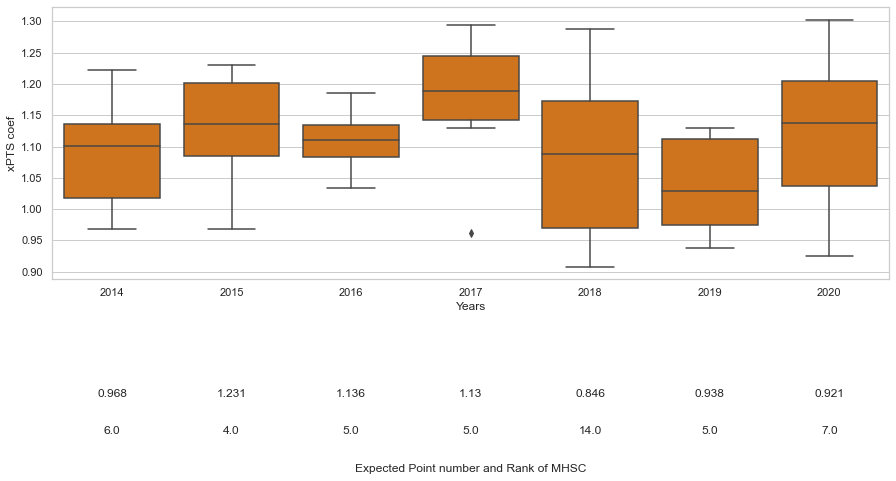

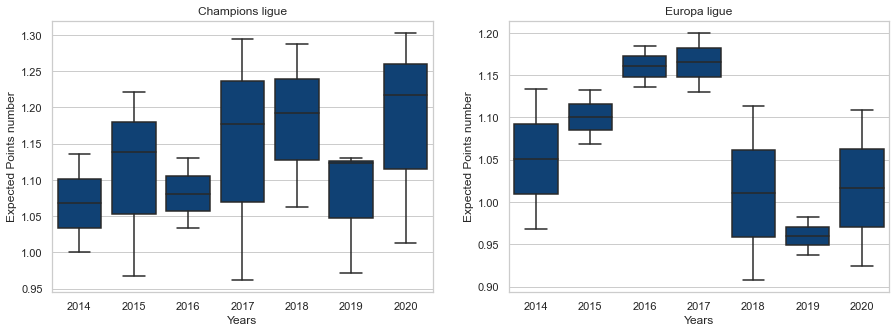

In [374]:
plt.figure(figsize=[15,5])
sns.boxplot(x='Years',y='xPTS coef',data=euro_ligue_corr,color='#ED7300')  
rects = year
labels_point = list(ars_expect_point.values[0])
labels_rank = list(ars_expect_point.values[1])
plt.text(3,0.58,'Expected Point number and Rank of MHSC',horizontalalignment='center')
for rect, label1,label2 in zip(range(0,(len(rects))), labels_point,labels_rank):
    height = label
    plt.text(rect, 0.7, label1,horizontalalignment='center')
    plt.text(rect, 0.64, label2,horizontalalignment='center')
plt.show()
# print()[].T)
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[euro_ligue_corr['Rank'] < 4],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Champions ligue')
plt.subplot(122)
sns.boxplot(x="Years",y='xPTS coef',data=euro_ligue_corr[(euro_ligue_corr['Rank'] > 4)&(euro_ligue_corr['Rank'] < 8)],color='#004184')
plt.ylabel('Expected Points number')
plt.title('Europa ligue')
plt.show()

# Valeurs marchandes

In [396]:
df_euro

,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions),Years,Crew
0,Gardien,"26,00",28.5,9.50,2014,barcelona
1,Défense,"25,90",124.2,12.42,2014,barcelona
2,Milieu de terrain,"23,91",151.1,13.74,2014,barcelona
3,Attaquant,"22,29",300.0,42.86,2014,barcelona
4,Total,"24,39",603.8,19.48,2014,barcelona
...,...,...,...,...,...,...
1073,Gardien,"23,50",9.1,2.28,2020,eibar
1074,Défense,"26,08",22.4,1.72,2020,eibar
1075,Milieu de terrain,"26,00",9.8,1.40,2020,eibar
1076,Attaquant,"27,10",42.1,4.21,2020,eibar


In [397]:
# for e,a,u in zip(df_euro['Valeur marchande (millions)'],df_euro['Crew'],df_euro['Positions']):
#     if 'K' in e:
#         print(e,a,u)

In [398]:
df_euro.dropna(axis=0,inplace=True)

In [399]:
# df_value_1 = []
# df_value_2 = []
# for i,e in zip(df_euro['Valeur marchande (millions)'],df_euro['Valeur marchande moyenne (millions)']):
#     if ('K' in e)&('K' in i):
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in e:
#         df_value_1.append(float(i.replace(',','.')))
#         df_value_2.append(float(e.split(' ')[0])/1000)
#     elif 'K' in i:
#         df_value_1.append(float(i.split(' ')[0])/1000)
#         df_value_2.append(float(e.replace(',','.')))
#     else:
#         df_value_1.append(i.replace(',','.'))
#         df_value_2.append(i.replace(',','.'))

In [400]:
# df_euro['Valeur marchande (millions)'] = df_value_1
# df_euro['Valeur marchande moyenne (millions)'] = df_value_2

In [401]:
df_euro['Âge'] = [i.replace(',','.') for i in df_euro['Âge']] 
# df_euro['Valeur marchande (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.replace(',','.') for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande moyenne (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande moyenne (millions)']] 
# df_euro['Valeur marchande (millions)'] = [i.split(' ')[0] for i in df_euro['Valeur marchande (millions)']] 

In [402]:
column = ['Âge', 'Valeur marchande (millions)',
       'Valeur marchande moyenne (millions)']
for i in column:
    df_euro[i] = df_euro[i].astype(float)

In [403]:
ars_max = value_max[value_max['Crew'] == 'fc-villarreal']

In [404]:
total = df_euro[(df_euro['Crew'] == 'fc-villarreal')&(df_euro['Positions'] == 'Total')]

In [405]:
# print(df_euro['Crew'].unique())
# print(euro_ligue_corr['Team'].unique())

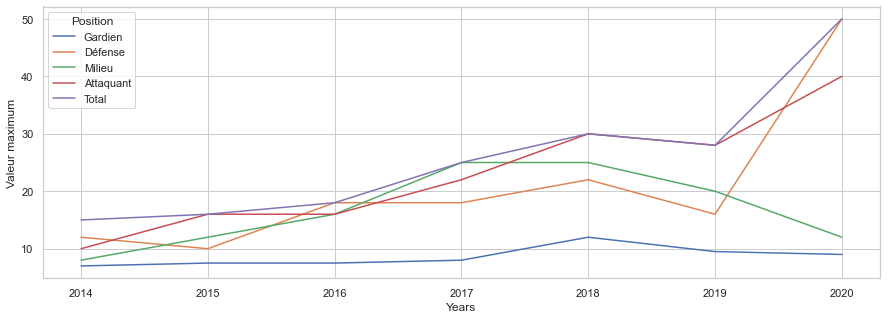

In [406]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur maximum',hue='Position',data=ars_max)
plt.show()

In [407]:
# ligue_corr['Team'].unique()

In [408]:
# list(df_euro['Team'].unique()[10:])

In [409]:
print(ligue_corr['Team'].unique())
print(df_euro['Crew'].unique())

['Barcelona' 'Real Madrid' 'Atletico Madrid' 'Valencia' 'Sevilla'
 'Villarreal' 'Athletic Club' 'Celta Vigo' 'Malaga' 'Espanyol'
 'Rayo Vallecano' 'Real Sociedad' 'Elche' 'Getafe' 'Levante' 'Eibar'
 'Deportivo La Coruna' 'Granada' 'Almeria' 'Cordoba' 'Real Betis'
 'Las Palmas' 'Sporting Gijon' 'Alaves' 'Leganes' 'Osasuna' 'Girona'
 'Real Valladolid' 'SD Huesca' 'Mallorca' 'Cadiz']
[' barcelona' 'real madrid' 'atletico madrid' ' valencia' ' sevilla'
 ' villarreal' 'athletic bilbao' 'celta vigo' ' malaga'
 'espanyol barcelona' 'rayo vallecano' 'real sociedad san sebastian'
 ' elche' ' getafe' 'ud levante' 'deportivo la coruna' ' granada'
 'ud almeria' ' cordoba' 'real betis sevilla' 'ud las palmas'
 'sporting gijon' 'deportivo alaves' 'cd leganes' 'ca osasuna' ' girona'
 'real valladolid' 'sd huesca' 'rcd mallorca' ' cadiz' 'eibar']


In [153]:
    

     
      
   ' 

'ChelseaManchester City'

In [503]:
df_euro['Crew'] = [i.replace(' barcelona','Barcelona') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('real madrid','Real Madrid') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('atletico madrid','Atletico Madrid') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' valencia','Valencia') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' sevilla','Sevilla') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' villarreal','Villarreal') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('athletic bilbao','Athletic Club') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('celta vigo','Celta Vigo') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' malaga','Malaga') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('espanyolBarcelona','Espanyol') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('rayo vallecano','Rayo Vallecano') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('real sociedad san sebastian','Real Sociedad') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' elche','Elche') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' getafe','Getafe') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ud levante','Levante') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('eibar','Eibar') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('deportivo la coruna','Deportivo La Coruna') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' granada','Granada') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ud almeria','Almeria') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace(' cordoba','Cordoba') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('real betisSevilla','Real Betis') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('ud las palmas','Las Palmas') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('sporting gijon','Sporting Gijon') for i in df_euro['Crew']] 
df_euro['Crew'] = [i.replace('deportivo alaves','Alaves') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('cd leganes','Leganes') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('ca osasuna','Osasuna') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace(' girona','Girona') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('real valladolid','Real Valladolid') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('sd huesca','SD Huesca') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace('rcd mallorca','Mallorca') for i in df_euro['Crew']]
df_euro['Crew'] = [i.replace(' cadiz','Cadiz') for i in df_euro['Crew']]


In [504]:
df_euro['Crew'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo', 'Malaga',
       'Espanyol', 'Rayo Vallecano', 'Real Sociedad', 'Elche', 'Getafe',
       'Levante', 'Deportivo La Coruna', 'Granada', 'Almeria', 'Cordoba',
       'Real Betis', 'Las Palmas', 'Sporting Gijon', 'Alaves', 'Leganes',
       'Osasuna', 'Girona', 'Real Valladolid', 'SD Huesca', 'Mallorca',
       'Cadiz', 'Eibar'], dtype=object)

In [415]:
df_euro.rename(columns={'Crew':'Team'},inplace=True)

In [505]:
df_lig_val = ligue_corr.merge(df_euro,how='inner',on=['Team','Years'])

In [506]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Gardien,26.00,28.5,9.50
1,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Défense,25.90,124.2,12.42
2,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Milieu de terrain,23.91,151.1,13.74
3,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Attaquant,22.29,300.0,42.86
4,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Total,24.39,603.8,19.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Gardien,23.50,9.1,2.28
696,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Défense,26.08,22.4,1.72
697,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Milieu de terrain,26.00,9.8,1.40
698,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Attaquant,27.10,42.1,4.21


In [463]:
plt.figure(figsize=[15,5])
sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
sns.lineplot(x='Years',y='PTS',data=ars,label='Points')
sns.lineplot(x='Years',y='xPTS',data=ars,label='Expected points')
# rects = year
# labels_rank = list(ars['Rank'])
# plt.text(3,0.32,'Point number and Rank of MHSC',horizontalalignment='center')
# for rect, label in zip(range(0,len(rects)), labels_rank):
#     plt.text(rect, 0.36, label,horizontalalignment='center')
plt.show()

ValueError: Could not interpret value `Years` for parameter `x`

<Figure size 1080x360 with 0 Axes>

### Corrélation valeurs marchande / résultats 

In [507]:
df_lig_val

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Gardien,26.00,28.5,9.50
1,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Défense,25.90,124.2,12.42
2,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Milieu de terrain,23.91,151.1,13.74
3,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Attaquant,22.29,300.0,42.86
4,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Total,24.39,603.8,19.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Gardien,23.50,9.1,2.28
696,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Défense,26.08,22.4,1.72
697,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Milieu de terrain,26.00,9.8,1.40
698,20,Eibar,38,6,12,20,29,52,30,42.45,48.84,48.62,2020,0.690,1.083,0.625,Attaquant,27.10,42.1,4.21


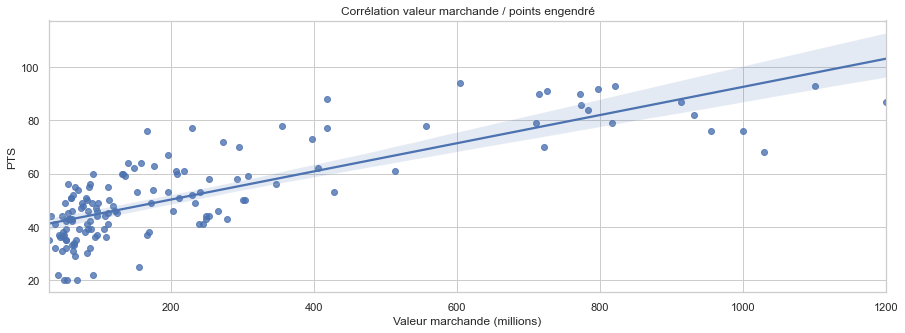

Covariance empirique :  3700.1617071428586
Coefficient de Pearson :  0.794136644885606

Les valeurs suivent une distribution linéaire


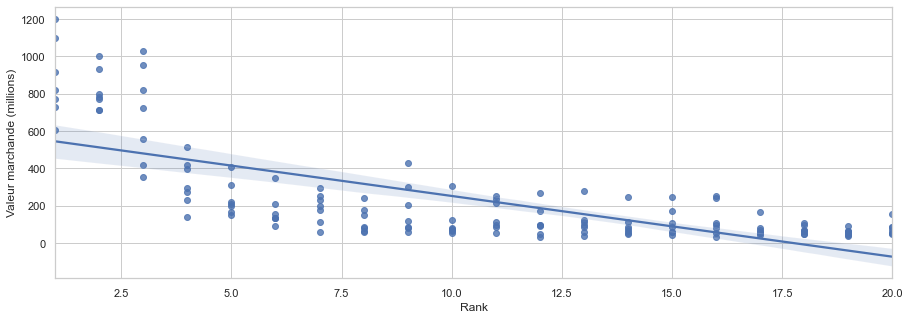

Covariance empirique :  -1080.3795357142856
Coefficient de Pearson :  -0.7092242089866279

Les valeurs suivent une distribution linéaire


In [508]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='PTS',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["PTS"])
plt.figure(figsize=[15,5])
sns.regplot(x='Rank',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']['Rank'],df_lig_val[df_lig_val['Positions'] == 'Total']['Valeur marchande (millions)'])


### Corrélation valeurs marchande / buts marqués - encaissés

In [509]:
df_lig_val[(df_lig_val['G'] > 50)&(df_lig_val['Positions'] == 'Attaquant')]

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
3,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Attaquant,22.29,300.00,42.86
8,2,Real Madrid,38,30,2,6,118,38,92,95.77,42.61,81.75,2014,1.242,0.905,1.136,Attaquant,23.33,340.00,37.78
13,3,Atletico Madrid,38,23,9,6,67,29,78,57.05,29.07,73.14,2014,1.175,1.000,1.068,Attaquant,23.64,143.50,13.05
18,4,Valencia,38,22,11,5,70,32,77,55.06,39.39,63.71,2014,1.273,0.821,1.222,Attaquant,23.50,85.00,14.17
23,5,Sevilla,38,23,7,8,71,45,76,69.53,47.86,67.39,2014,1.029,0.957,1.134,Attaquant,23.33,63.75,7.08
103,1,Barcelona,38,29,4,5,112,29,91,113.60,34.03,94.38,2015,0.991,0.853,0.968,Attaquant,23.10,378.00,37.80
108,2,Real Madrid,38,28,6,4,110,34,90,90.45,45.23,79.09,2015,1.222,0.756,1.139,Attaquant,23.63,284.00,35.50
113,3,Atletico Madrid,38,28,4,6,63,18,88,54.93,27.80,72.28,2015,1.167,0.667,1.222,Attaquant,23.56,152.00,16.89
123,5,Athletic Club,38,18,8,12,58,45,62,53.90,45.33,58.24,2015,1.094,1.000,1.069,Attaquant,26.88,48.00,6.00
128,6,Celta Vigo,38,17,9,12,51,59,60,50.20,51.98,53.08,2015,1.020,1.157,1.132,Attaquant,24.25,39.30,4.91


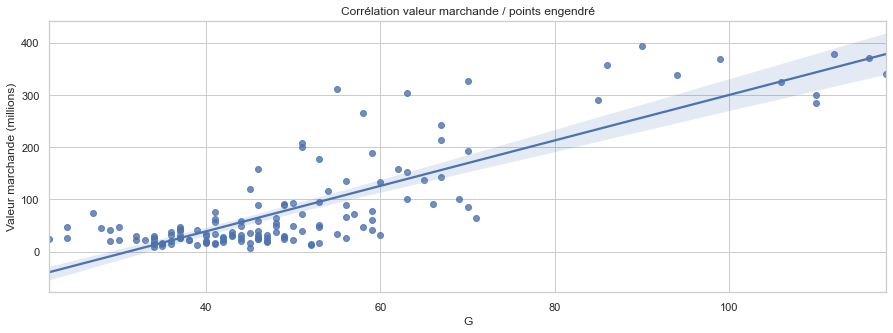

Covariance empirique :  1528.3874448979589
Coefficient de Pearson :  0.8327720659428678

Les valeurs suivent une distribution linéaire


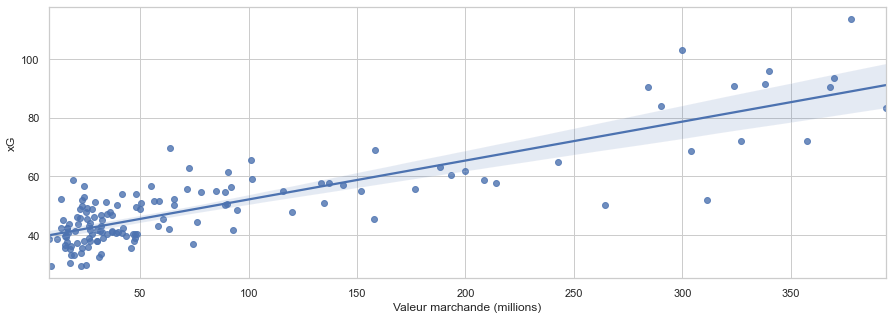

Covariance empirique :  1267.6774535816326
Coefficient de Pearson :  0.847674911789246

Les valeurs suivent une distribution linéaire


In [510]:
# buts marqués
plt.figure(figsize=[15,5])
sns.regplot(x='G',y='Valeur marchande (millions)',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.title('Corrélation valeur marchande / points engendré')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']["G"],df_lig_val[df_lig_val['Positions'] == 'Attaquant']["Valeur marchande (millions)"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xG',data=df_lig_val[df_lig_val['Positions'] == 'Attaquant'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Attaquant']['Valeur marchande (millions)'],df_lig_val[df_lig_val['Positions'] == 'Attaquant']['xG'])


In [511]:
df_lig_val[df_lig_val['Positions'] == 'Gardien']

,Rank,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,Years,xG coef,xGA coef,xPTS coef,Positions,Âge,Valeur marchande (millions),Valeur marchande moyenne (millions)
0,1,Barcelona,38,30,4,4,110,21,94,102.98,28.44,94.08,2014,1.078,0.750,1.000,Gardien,26.00,28.50,9.500
5,2,Real Madrid,38,30,2,6,118,38,92,95.77,42.61,81.75,2014,1.242,0.905,1.136,Gardien,27.00,24.80,4.960
10,3,Atletico Madrid,38,23,9,6,67,29,78,57.05,29.07,73.14,2014,1.175,1.000,1.068,Gardien,24.00,15.00,5.000
15,4,Valencia,38,22,11,5,70,32,77,55.06,39.39,63.71,2014,1.273,0.821,1.222,Gardien,25.67,10.50,3.500
20,5,Sevilla,38,23,7,8,71,45,76,69.53,47.86,67.39,2014,1.029,0.957,1.134,Gardien,23.60,7.30,1.460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,16,Alaves,38,9,11,18,36,57,38,39.11,51.55,43.23,2020,0.923,1.118,0.884,Gardien,24.33,9.05,3.020
680,17,Elche,38,8,12,18,34,55,36,30.40,61.63,30.31,2020,1.133,0.902,1.200,Gardien,21.17,5.35,0.892
685,18,SD Huesca,38,7,13,18,34,53,34,37.98,48.64,45.23,2020,0.919,1.104,0.756,Gardien,24.50,4.90,1.230
690,19,Real Valladolid,38,5,16,17,34,57,31,37.92,52.56,41.53,2020,0.919,1.096,0.756,Gardien,27.75,3.10,0.775


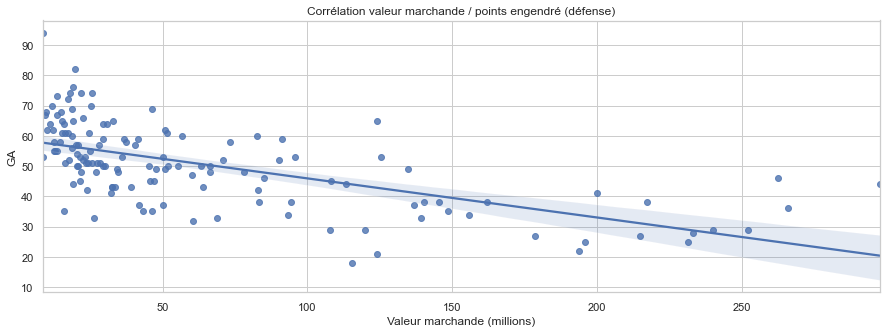

Covariance empirique :  -548.0364265306122
Coefficient de Pearson :  -0.6224121925657498

Les valeurs suivent une distribution linéaire


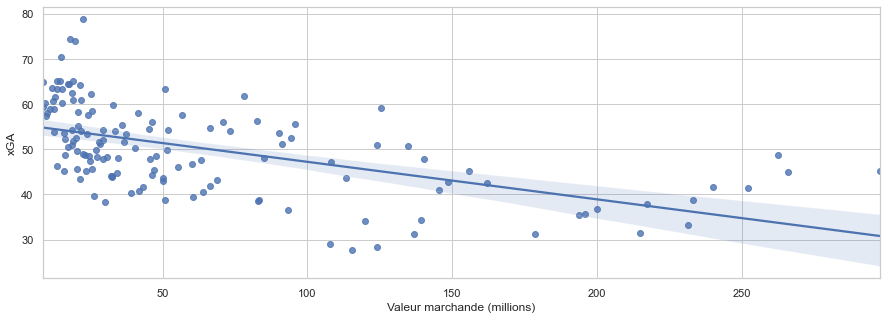

Covariance empirique :  -352.5731601938776
Coefficient de Pearson :  -0.5507632480499554

Les valeurs suivent une distribution linéaire


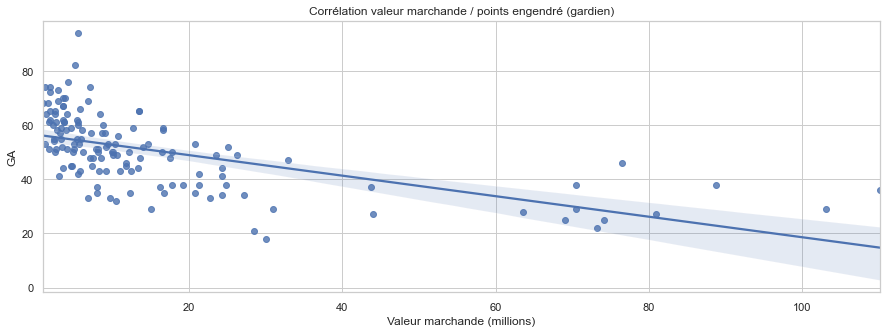

Covariance empirique :  -165.99492448979584
Coefficient de Pearson :  -0.5865764311860199

Les valeurs suivent une distribution linéaire


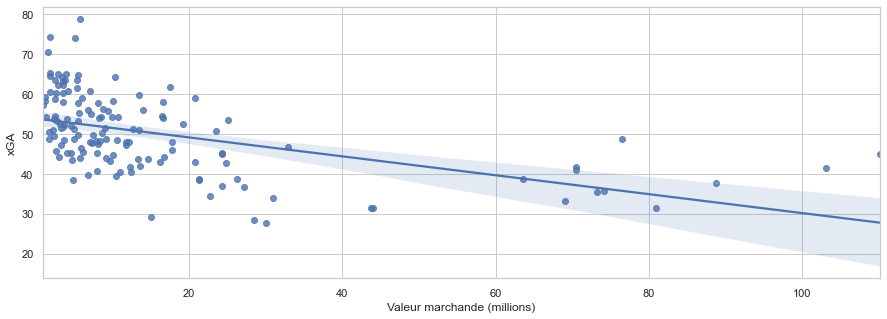

Covariance empirique :  -103.91208824489802
Coefficient de Pearson :  -0.5050599260542441

Les valeurs suivent une distribution linéaire


In [512]:
# buts encaissé
#défense
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Défense']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Défense'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Défense']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Défense']['Valeur marchande (millions)'])
#gardien
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='GA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.title('Corrélation valeur marchande / points engendré (gardien)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Gardien']["GA"])
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='xGA',data=df_lig_val[df_lig_val['Positions'] == 'Gardien'])
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Gardien']['xGA'],df_lig_val[df_lig_val['Positions'] == 'Gardien']['Valeur marchande (millions)'])


In [513]:
df_lig_val['Years'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [514]:
df_lig_val['win_rate'] = np.around(df_lig_val['W']/df_lig_val['M'],decimals=3)

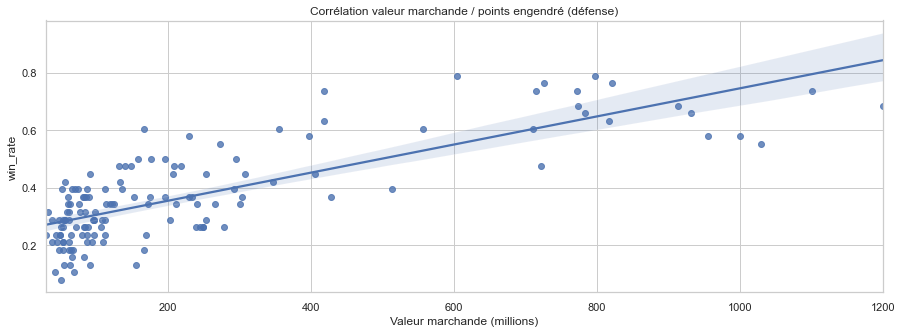

Covariance empirique :  34.12814448928572
Coefficient de Pearson :  0.7827490694547322

Les valeurs suivent une distribution linéaire


In [515]:
plt.figure(figsize=[15,5])
sns.regplot(x='Valeur marchande (millions)',y='win_rate',data=df_lig_val[df_lig_val['Positions'] == 'Total'])
plt.title('Corrélation valeur marchande / points engendré (défense)')
plt.show()
corré_quant(df_lig_val[df_lig_val['Positions'] == 'Total']["Valeur marchande (millions)"],df_lig_val[df_lig_val['Positions'] == 'Total']["win_rate"])

In [516]:
df_lig_val['Team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo', 'Malaga',
       'Espanyol', 'Rayo Vallecano', 'Real Sociedad', 'Elche', 'Getafe',
       'Levante', 'Eibar', 'Deportivo La Coruna', 'Granada', 'Almeria',
       'Cordoba', 'Real Betis', 'Las Palmas', 'Sporting Gijon', 'Alaves',
       'Leganes', 'Osasuna', 'Girona', 'Real Valladolid', 'SD Huesca',
       'Mallorca', 'Cadiz'], dtype=object)

In [517]:
df_value_pond_av = []
for i in list(df_lig_val['Team'].unique()):
    for a in list(df_lig_val['Years'].unique()):
        try:
            gardien = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Gardien')]['Valeur marchande (millions)'])
            defense = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Défense')]['Valeur marchande (millions)'])
            milieu = 0.5*int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Milieu de terrain')]['Valeur marchande (millions)'])
            attaque = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Attaquant')]['Valeur marchande (millions)'])
            total = int(df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Valeur marchande (millions)'])
            rank = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['Rank']
            pts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['PTS']
            buts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['G']
            buts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['GA']
            xbuts = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xG']
            xbuts_enc = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['xGA']
            win_rate = df_lig_val[(df_lig_val['Team'] == i)&(df_lig_val['Years'] == a)&(df_lig_val['Positions'] == 'Total')]['win_rate']

            df_value_pond_av.append(pd.DataFrame({'Rank':rank,'Team':i,'Years':a,'PTS':pts,'win_rate':win_rate,'G':buts,'GA':buts_enc,'xG':xbuts,'xGA':xbuts_enc,'Value totale':total,'Value attaque': np.around((attaque+milieu*0.25)/1.25,decimals=3),'Value défense': np.around((gardien*0.5+defense*1.25+milieu*0.25)/2,decimals=3)}))
        except TypeError:
            continue

In [518]:
value_pond_av = pd.concat(df_value_pond_av)

In [519]:
value_pond_av.to_csv('pond_value_liga.csv', index=False)

### Corrélation valeurs marchande pondérée / buts marqués - encaissés

In [2]:
value_pond = pd.read_csv('pond_value_liga.csv',sep=',')

In [521]:
value_pond[value_pond['Years'] == 2018]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense
4,1,Barcelona,2018,87,0.684,90,36,83.28,44.93,1200,358.3,206.938
11,3,Real Madrid,2018,68,0.553,63,46,68.65,48.68,1030,282.1,197.562
18,2,Atletico Madrid,2018,76,0.579,55,29,51.87,41.43,1000,282.1,191.188
25,4,Valencia,2018,61,0.395,51,35,61.88,42.85,513,173.6,104.000
32,5,Sevilla,2018,59,0.447,62,47,69.16,46.71,308,132.0,45.000
39,14,Villarreal,2018,44,0.263,49,52,54.80,56.12,248,78.7,50.688
46,8,Athletic Club,2018,53,0.342,41,45,44.44,47.16,240,65.2,71.625
53,16,Celta Vigo,2018,41,0.263,53,62,48.70,63.43,240,84.1,37.438
64,7,Espanyol,2018,53,0.368,48,50,50.16,54.62,195,58.1,45.312
68,20,Rayo Vallecano,2018,32,0.211,41,70,47.23,62.32,86,29.5,17.438


In [522]:
df_player

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,year
0,2371,Cristiano Ronaldo,35,3103,48,39.3088,16,13.6006,225,76,5,1,F M,Real Madrid,38,30.3897,43.6080,7.5202,2014
1,2097,Lionel Messi,38,3374,43,35.8918,18,17.6120,187,95,4,0,F S,Barcelona,38,31.4321,54.7536,19.7567,2014
2,2099,Neymar,33,2573,22,22.7216,7,8.2615,95,52,6,0,F S,Barcelona,21,21.9783,36.8882,11.6784,2014
3,2270,Antoine Griezmann,37,2490,22,14.7097,1,2.6077,78,23,6,0,F M S,Atletico Madrid,22,14.7097,18.4795,4.5516,2014
4,1125,Carlos Bacca,37,2581,20,19.2792,6,4.7282,69,31,4,0,F S,Sevilla,14,13.3337,16.0863,2.6682,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,9457,José Boacho,4,21,0,0.0186,0,0.0000,1,0,1,0,S,Getafe,0,0.0186,0.0335,0.0149,2020
3813,9496,Alejandro Cantero,4,245,0,0.4423,0,1.0826,3,3,1,0,F S,Levante,0,0.4423,1.4155,0.3263,2020
3814,9519,Carlos Domínguez,4,360,0,0.0675,0,0.0349,1,1,2,0,D,Celta Vigo,0,0.0675,0.2483,0.2483,2020
3815,9520,Hugo Sotelo,1,1,0,0.0000,0,0.0000,0,0,0,0,S,Celta Vigo,0,0.0000,0.0000,0.0000,2020


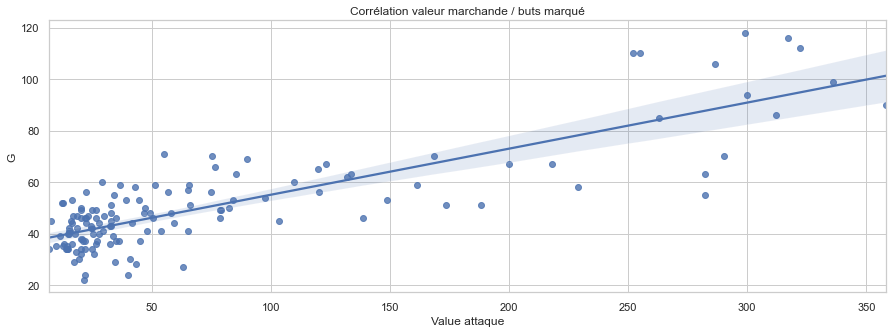

Covariance empirique :  1347.4195102040824
Coefficient de Pearson :  0.8283518618692554

Les valeurs suivent une distribution linéaire


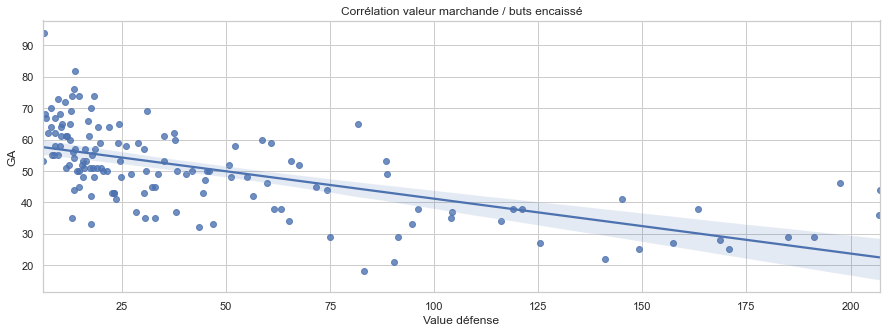

Covariance empirique :  -406.4890959183676
Coefficient de Pearson :  -0.6238848734238693

Les valeurs suivent une distribution linéaire


In [523]:
# buts marqué
#défense
plt.figure(figsize=[15,5])
sns.regplot(x="Value attaque",y='G',data=value_pond)
plt.title('Corrélation valeur marchande / buts marqué')
plt.show()
corré_quant(value_pond["Value attaque"],value_pond["G"])
plt.figure(figsize=[15,5])
sns.regplot(x='Value défense',y='GA',data=value_pond)
plt.title('Corrélation valeur marchande / buts encaissé')
plt.show()
corré_quant(value_pond['Value défense'],value_pond['GA'])

In [436]:
headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = ['https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=140052&set=true&offset=',
        'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=150059&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=160058&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=170099&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=180084&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=190075&set=true&offset=',
       'https://sofifa.com/players?type=all&lg%5B0%5D=53&showCol%5B0%5D=ae&showCol%5B1%5D=hi&showCol%5B2%5D=bp&showCol%5B3%5D=ta&showCol%5B4%5D=ts&showCol%5B5%5D=to&showCol%5B6%5D=ac&showCol%5B7%5D=sp&showCol%5B8%5D=td&showCol%5B9%5D=tg&hl=fr-FR&r=200061&set=true&offset=']

In [437]:
b = 0
list_error_name = [' L. Messi',' L. Messi',' L. Messi',' Cristiano Ronaldo',' L. Messi',' L. Messi',' L. Messi']
list_page_glob = []
x = 2014
for i in page:
    y = 0
    list_page = []
    while str(requests.get("{}{}".format(str(i),str(y)), headers=headers)) == '<Response [200]>':
        print(x,y)
        #print("{}{}".format(str(i),str(y)),"{}{}".format(str(i),str(y))=='https://sofifa.com/players')
        pageTree = requests.get("{}{}".format(str(i),str(y)), headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        name = str(soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')[0].find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text)
        #print("{}{}".format(str(i),str(y)),name,b)
        if (str(name) == list_error_name[b])&(y >= 660):
            b = b + 1
            break
        else:
            list_name = []
            list_name.append(name)
            print(list_name)
            list_page.append("{}{}".format(str(i),str(y)))
            y = y +60
    x = x +1
    list_page_glob.append(list_page)

2014 0
[' L. Messi']
2014 60
[' Mikel Gonzalez']


KeyboardInterrupt: 

In [276]:


df_fifa = []
x = 2014

for k in list_page_glob:
    #print(k)
    for e in k:
        pageTree = requests.get(e, headers=headers)
        soup = BeautifulSoup(pageTree.content, 'html.parser')
        
        value = soup.body.find('div',{'class':'column col-auto'}).table.tbody.find_all('tr')
        #print(value)
        for i in value:
            
            name = i.find('td',{"class":'col-name'}).find('div',{'class':'bp3-text-overflow-ellipsis'}).text
            age = i.find('td',{'class':'col col-ae'}).text
            club = i.find_all('td',{'class':'col-name'})[1].find('div',{'class':'bp3-text-overflow-ellipsis'}).a.text
#             print(i)
            poste = i.find('td',{'class':'col col-bp'}).text
            poid = i.find('td',{'class':'col col-hi'}).text
            accele = int(i.find('td',{'class':'col col-sp'}).span.text)
            speed = int(i.find('td',{'class':'col col-ac'}).span.text)
            offensif = int(i.find('td',{'class':'col col-ta'}).span.text)
            tech = int(i.find('td',{'class':'col col-ts'}).span.text)
            mouv = int(i.find('td',{'class':'col col-to'}).span.text)
            def_gene = int(i.find('td',{'class':'col col-td'}).span.text)
            gardien = int(i.find('td',{'class':'col col-tg'}).span.text)
            df_fifa.append(pd.DataFrame({'name':[name],'poste':[poste],'Team':[club],'taille':[poid],'accélération':[accele],'speed':[speed],'offensif':[offensif],'technique':[tech],'mouvement':[mouv],'defense general':[def_gene],'gardien general':[gardien],'Years':x}))

        #print(df_fifa)
    x = x + 1
#     print(x)
fifa = pd.concat(df_fifa)

In [277]:
# for i in fifa[fifa['Years'] == 2020]['poid']:
#     print(i.split('"')[0])
#     dist = Distance(=i.split('"')[0].split("'")[0],inch=i.split('"')[0].split("'")[1])
#     print(dist.m)

In [278]:
fifa

,name,poste,Team,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general,Years
0,L. Messi,MOC,FC Barcelone,"5'7""",88,96,431,442,469,66,54,2014
0,Cristiano Ronaldo,BU,Real Madrid,"6'1""",94,91,428,424,443,76,58,2014
0,Iniesta,MOC,FC Barcelone,"5'7""",75,76,381,419,410,170,45,2014
0,Xavi,MOC,FC Barcelone,"5'7""",65,67,371,437,395,177,46,2014
0,G. Bale,MD,Real Madrid,"6'0""",94,92,401,424,412,213,52,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
0,Martínez,BU,Real Sociedad,"6'5""",55,54,259,212,249,39,51,2020
0,Cubero,DLD,SD Eibar,"6'2""",62,65,207,226,291,162,55,2020
0,Atienza,MC,SD Eibar,"6'1""",55,59,212,235,286,142,64,2020
0,Guille Amor,MOC,Getafe CF,"5'10""",59,65,249,287,297,136,51,2020


In [279]:
fifa.to_csv('fifa_glob_liga.csv',index=False)

In [3]:
fifa = pd.read_csv('fifa_glob_liga.csv',sep=',')

In [4]:
list_taille = []
for i in fifa['taille']:
    list_taille.append(np.around(int(i.split('"')[0].split("'")[0])*30.48 + int(i.split('"')[0].split("'")[1])*2.54,decimals=0))

In [5]:
fifa['taille'] = list_taille

In [6]:
moy_playeurs = fifa.groupby(['poste','Years']).mean().reset_index()

In [7]:
moy_playeurs

,poste,Years,taille,accélération,speed,offensif,technique,mouvement,defense general,gardien general
0,AD,2014,174.926829,78.926829,81.853659,299.268293,335.121951,386.146341,91.219512,49.390244
1,AD,2015,175.948718,81.128205,82.179487,315.025641,343.564103,388.512821,97.076923,49.974359
2,AD,2016,176.037037,80.148148,82.111111,322.481481,345.370370,386.407407,87.148148,53.666667
3,AD,2017,173.615385,77.923077,80.384615,318.692308,334.538462,384.538462,96.692308,51.307692
4,AD,2018,175.777778,79.888889,80.444444,320.222222,314.666667,376.333333,80.444444,54.777778
...,...,...,...,...,...,...,...,...,...,...
100,MOC,2016,177.569231,66.569231,69.492308,308.461538,349.600000,346.769231,121.753846,53.046154
101,MOC,2017,176.623656,69.602151,72.172043,325.139785,363.365591,359.236559,114.086022,52.817204
102,MOC,2018,176.377778,70.566667,72.655556,319.977778,355.433333,362.500000,124.133333,53.477778
103,MOC,2019,176.547619,69.642857,72.321429,318.559524,356.107143,361.904762,145.428571,53.892857


In [8]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['BU','MOC', 'AG', 'AD','AT','MC']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['accélération'],value['speed'],value['offensif'],value['technique'],value['mouvement']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(k/int(value_moy['accélération']),decimals=3)
            speedo = np.around(a/int(value_moy['speed']),decimals=3)
            offense = np.around(j/int(value_moy['offensif']),decimals=3)
            tech = np.around(l/int(value_moy['technique']),decimals=3)
            mouv = np.around(g/int(value_moy['mouvement']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e],'accélération':[accel], 'speed':[speedo], 'offensif':[offense],
       'technique':[tech], 'mouvement':[mouv], 'Years':[i]}))
off_coef = pd.concat(df_off_coef)

In [9]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    poste = ['DC', 'MDC', 'DLG','DG', 'DLD', 'DD']
    for e in poste:
        value = fifa[(fifa['Years'] == i)&(fifa['poste'] == e)]
        for q,k,a,j,l,g in zip_longest(value['Team'],value['taille'],value['accélération'],value['speed'],value['defense general'],value['gardien general']):
            #print(q,k,a,i,l,g)
            value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == e)]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
            accel = np.around(a/int(value_moy['accélération']),decimals=3)
            speedo = np.around(j/int(value_moy['speed']),decimals=3)
            tail = np.around(k/float(value_moy['taille']),decimals=3)
            def_gene = np.around(l/int(value_moy['defense general']),decimals=3)
            df_off_coef.append(pd.DataFrame({'Team':[q],'poste':[e], 'taille':[tail],'accélération':[accel], 'speed':[speedo],
       'defense generale':[def_gene], 'Years':[i]}))
def_coef = pd.concat(df_off_coef)

In [10]:
from itertools import zip_longest
years = fifa['Years'].unique()
df_off_coef = []
for i in years:
    value = fifa[(fifa['Years'] == i)&(fifa['poste'] == 'G')]
    for q,k,a in zip_longest(value['Team'],value['taille'],value['gardien general']):
        value_moy = moy_playeurs[(moy_playeurs['Years'] == i)&(moy_playeurs['poste'] == 'G')]
#             print(value_moy['accélération'],value_moy['speed'],value_moy['offensif'],value_moy['technique'],value_moy['mouvement'])
        tail = np.around(k/float(value_moy['taille']),decimals=3)
        gard = np.around(a/int(value_moy['gardien general']),decimals=3)
        df_off_coef.append(pd.DataFrame({'Team':[q],'poste':'G', 'taille':[tail],'gardien generale':[gard], 'Years':[i]}))
gard_coef = pd.concat(df_off_coef)

In [11]:
gard_coef['coef'] = np.around((gard_coef['taille']+gard_coef['gardien generale']*1.5)/2.5,decimals=5)

In [12]:
def_coef['coef'] = np.around((def_coef['taille']+def_coef['accélération']+def_coef['speed']+def_coef['defense generale']*1.5)/4.5,decimals=5)

In [13]:
off_coef['coef'] = np.around((off_coef['offensif']*1.5+off_coef['accélération']+off_coef['speed']+off_coef['mouvement']+off_coef['technique'])/5.5,decimals=5)

In [14]:
def_coef = def_coef[['Team','poste','Years','coef']]

In [15]:
gard_coef = gard_coef[['Team','poste','Years','coef']]

In [16]:
off_coef = off_coef[['Team','poste','Years','coef']]

In [17]:
list_def_coef = []
def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5
list_def_coef.append(def_coef[def_coef['poste'] == 'DC'])
list_def_coef.append(def_coef[def_coef['poste'] != 'DC'])
list_def_coef.append(gard_coef)
def_coef_glob = pd.concat(list_def_coef)

<ipython-input-17-03152599a842>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_coef[def_coef['poste'] == 'DC']['coef'] = def_coef[def_coef['poste'] == 'DC']['coef']*1.5


In [18]:
list_off_coef = []
off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75
list_off_coef.append(off_coef[off_coef['poste'] == 'MC'])
list_off_coef.append(off_coef[off_coef['poste'] != 'MC'])
off_coef_glob = pd.concat(list_off_coef)

<ipython-input-18-f028df8da51d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_coef[off_coef['poste'] == 'MC']['coef'] = off_coef[off_coef['poste'] == 'MC']['coef']*0.75


In [19]:
off_coef_glob = off_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [20]:
def_coef_glob = def_coef_glob.groupby(['Team','Years']).mean().reset_index().sort_values(by='coef',ascending=False)

In [21]:
df_coef = def_coef_glob.merge(off_coef_glob,how='inner',on=['Team','Years'])
df_coef.rename(columns={'coef_x':'coef défense','coef_y':'coef attaque'},inplace=True)

In [22]:
value_pond['Team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Valencia',
       'Sevilla', 'Villarreal', 'Athletic Club', 'Celta Vigo', 'Malaga',
       'Espanyol', 'Rayo Vallecano', 'Real Sociedad', 'Elche', 'Getafe',
       'Levante', 'Eibar', 'Deportivo La Coruna', 'Granada', 'Almeria',
       'Cordoba', 'Real Betis', 'Las Palmas', 'Sporting Gijon', 'Alaves',
       'Leganes', 'Osasuna', 'Girona', 'Real Valladolid', 'SD Huesca',
       'Mallorca', 'Cadiz'], dtype=object)

In [23]:
df_coef['Team'].unique()

array(['FC Barcelone', 'Real Madrid', 'Atlético Madrid', 'Valence CF',
       'Séville FC', 'Sporting Gijón', 'Athletic Bilbao', 'Villarreal CF',
       'Espanyol Barcelone', 'Real Betis Balompié', 'Málaga CF',
       'Levante UD', 'Getafe CF', 'Real Sociedad', 'Deportivo Alavés',
       'RC Celta', 'SD Eibar', 'Real Valladolid CF', 'Rayo Vallecano',
       'UD Almería', 'CA Osasuna', 'Grenade CF', 'UD Las Palmas',
       'CD Leganés', 'RCD Majorque', 'Deportivo La Corogne', 'Elche CF',
       'Girona CF', 'Córdoba CF', 'SD Huesca'], dtype=object)

In [30]:
value_pond['Team'] = [i.replace('Valencia','Valence CF') for i in value_pond['Team']] 
# value_pond['Team'] = [i.replace() for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Athletic Club','Athletic Bilbao') for i in value_pond['Team']]
value_pond['Team'] = [i.replace('Deportivo La Coruna','Deportivo La Corogne') for i in value_pond['Team']] 
value_pond['Team'] = [i.replace('Granada','Grenade CF') for i in value_pond['Team']]
df_coef['Team'] = [i.replace('Girona CF','Girona') for i in df_coef['Team']]

df_coef['Team'] = [i.replace('Séville FC','Sevilla') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Espanyol Barcelone','Espanyol') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Sporting Gijón','Sporting Gijon') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Atlético Madrid','Atletico Madrid') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('FC Barcelone','Barcelona') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('RC Celta','Celta Vigo') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('Deportivo Alavés','Alaves') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('SD Eibar','Eibar') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('UD Almería','Almeria') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Córdoba CF','Cordoba') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Villarreal CF','Villarreal') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Real Betis Balompié','Real Betis') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Málaga CF','Malaga') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Elche CF','Elche') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('Levante UD','Levante') for i in df_coef['Team']]  
df_coef['Team'] = [i.replace('Getafe CF','Getafe') for i in df_coef['Team']] 
df_coef['Team'] = [i.replace('UD Las Palmas','Las Palmas') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('CD Leganés','Leganes') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('RCD Majorque','Mallorca') for i in df_coef['Team']]
df_coef['Team'] = [i.replace('CA Osasuna','Osasuna') for i in df_coef['Team']]

In [28]:
value_pond['Team'] = [i.replace('Real Valladolid CF','Real Valladolid') for i in value_pond['Team']]
df_coef['Team'] = [i.replace('Real Valladolid CF','Real Valladolid') for i in df_coef['Team']]

In [31]:
for i,h in zip(df_coef['Team'].unique(),value_pond['Team'].unique()):
#     print(i,h)
    if (i not in df_coef['Team'].unique())|(i not in value_pond['Team'].unique()):
        print(i,'i')
    elif (h not in value_pond['Team'].unique())|(h not in df_coef['Team'].unique()):
        print(h,'k')

In [586]:
all_value

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque
0,1,Barcelona,2014,94,0.789,110,21,102.98,28.44,603,255.1,90.438,1.080319,1.120712
1,1,Barcelona,2015,91,0.763,112,29,113.60,34.03,726,322.1,91.188,1.088858,1.152534
2,2,Barcelona,2016,90,0.737,116,37,93.55,31.32,772,317.3,104.188,1.056790,1.046776
3,1,Barcelona,2017,93,0.737,99,29,90.49,41.62,1100,336.2,184.875,1.028201,1.054345
4,1,Barcelona,2018,87,0.684,90,36,83.28,44.93,1200,358.3,206.938,1.068090,1.097687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,13,Leganes,2018,45,0.289,37,43,41.25,43.94,112,35.0,23.000,0.976894,0.934825
114,18,Leganes,2019,36,0.211,30,51,38.92,45.62,109,41.0,18.000,0.992704,0.980581
115,11,Osasuna,2020,44,0.289,37,48,39.61,49.83,96,36.2,18.250,0.978549,1.001965
116,13,Real Valladolid,2019,42,0.237,32,43,35.66,53.94,87,20.6,23.000,1.002694,0.971342


In [32]:
all_value = value_pond.merge(df_coef,how='inner',on=['Team','Years'])

In [33]:
all_value.to_csv('merge_value_liga.csv',index=False)

In [34]:
all_value = pd.read_csv('merge_value_liga.csv',sep=',')

In [35]:
list_euro = []
list_euro_detail = []
for i in all_value['Rank']:
    if i < 7:
        list_euro.append('Européen')
        if i < 5: 
            list_euro_detail.append('CL')
        else:
            list_euro_detail.append('EL')
    else:
        list_euro.append('Non-Européen')
        list_euro_detail.append('NE')
all_value['is_euro'] = list_euro
all_value['is_euro_detail'] = list_euro_detail

In [36]:
#méthode de calcul et d'affichage des cercles de corrélation et de l'ACP

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, pca, axis_ranks, labels=None, alpha=1):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    
    fig_1 = plt.figure(figsize=(8,7))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.savefig('Eboulis.png')
    plt.show(block=False)

In [37]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail'],
      dtype='object')

In [38]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing

data = all_value[['PTS', 'G', 'GA', 'Value totale',
       'Value attaque', 'Value défense', 'coef défense', 'coef attaque','win_rate']]
X = data.values

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = decomposition.PCA(n_components = 4)
pca.fit(X_scaled)

PCA(n_components=4)

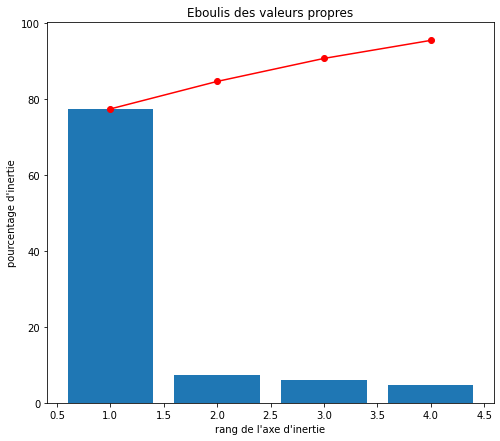

In [39]:
display_scree_plot(pca)

In [40]:
data

,PTS,G,GA,Value totale,Value attaque,Value défense,coef défense,coef attaque,win_rate
0,94,110,21,603,255.1,90.438,1.080319,1.120712,0.789
1,91,112,29,726,322.1,91.188,1.088858,1.152534,0.763
2,90,116,37,772,317.3,104.188,1.056790,1.046776,0.737
3,93,99,29,1100,336.2,184.875,1.028201,1.054345,0.737
4,87,90,36,1200,358.3,206.938,1.068090,1.097687,0.684
...,...,...,...,...,...,...,...,...,...
114,36,30,51,109,41.0,18.000,0.992704,0.980581,0.211
115,44,37,48,96,36.2,18.250,0.978549,1.001965,0.289
116,37,37,53,97,27.1,24.562,0.980229,0.982408,0.237
117,42,32,43,87,20.6,23.000,1.002694,0.971342,0.237


v1 : PTS
v2 : Buts marqués
v3 : Buts encaissés
v4 : Value totale
v5 : Value attaque
v6 : Value défense
v7 : coef défense
v8 : coef attaque
v9 : win rate


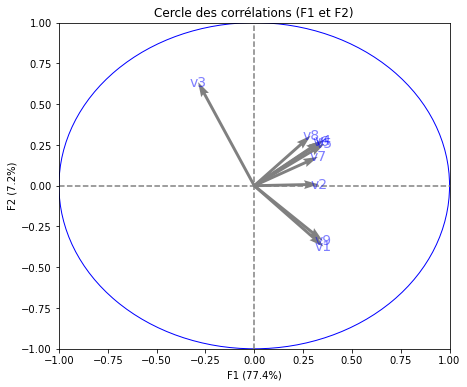

v3 est anti-corrélés aux variables PTS et coef attaque
v4,v5 et v6 ne sont corrélés à aucuns axes
v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information
     
F1 : Capacité à faire avoir de bonnes performances / bon classement
     
F2 : incapacité à défendre
     


In [41]:
#ACP
features = data.columns
pcs = pca.components_
var = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11']

print('v1 : PTS')
print('v2 : Buts marqués')
print('v3 : Buts encaissés')
print('v4 : Value totale')
print('v5 : Value attaque')
print('v6 : Value défense')
print('v7 : coef défense')
print('v8 : coef attaque')
print('v9 : win rate')

#display_circles(pcs, 4, pca, [(0,1),(2,3),(4,5)],labels = np.array(features))
display_circles(pcs, 4, pca, [(0,1)],labels = np.array(var))

X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected_2, 4, pca2, [(0,1),(2,3)], alpha = 0.2)

print('v3 est anti-corrélés aux variables PTS et coef attaque')
print('v4,v5 et v6 ne sont corrélés à aucuns axes')
print("v2,v7, v8 et v1 semblent être corrélés cependant les coefficients de corrélation sont plutôt faibles et traduisent une perte d'information")
print(' '*5)
print('F1 : Capacité à faire avoir de bonnes performances / bon classement')
print(' '*5)
print('F2 : incapacité à défendre')
print(' '*5)


plt.show()

In [42]:
f1 = []
f2 = []
for i in X_projected:
    f1.append(i[0])
    f2.append(i[1])
    
all_value['F1'] = f1
all_value['F2'] = f2

### La qualité de représentation des individus

In [43]:
data_compo = pd.DataFrame(X_projected,index=data.index,columns=["F"+str(i+1) for i in range(4)])
data_compo = data_compo.drop(['F3','F4'],axis=1)
data_compo

,F1,F2
0,6.100598,-0.707487
1,6.576647,0.370880
2,5.496078,0.023641
3,6.206258,0.275594
4,6.770580,1.656341
...,...,...
114,-2.123411,0.066130
115,-1.680758,-0.367680
116,-2.130813,0.009301
117,-1.763449,-0.541075


In [44]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data_compo.values
#instanciation
sc = StandardScaler()
#transformation
Z = sc.fit_transform(X)

In [45]:
data_compo['is_euro'] = all_value['is_euro']
data_compo['is_euro_detail'] = all_value['is_euro_detail']

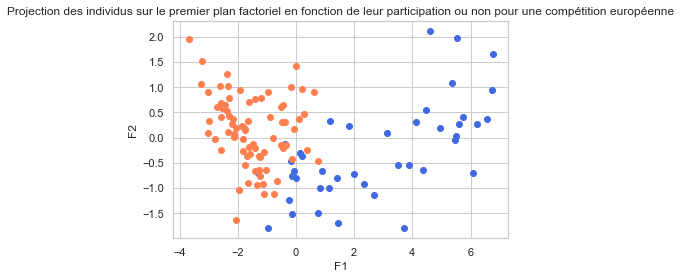

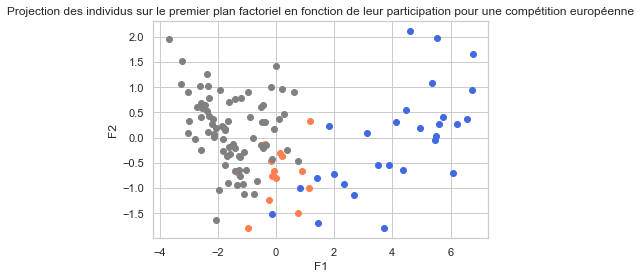

In [46]:
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro'] == 'Européen']['F1'],data_compo[data_compo['is_euro'] == 'Européen']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro'] == 'Non-Européen']['F1'],data_compo[data_compo['is_euro'] == 'Non-Européen']['F2'],c = 'coral')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation ou non pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()
figsize = [15,7]
sns.set(style="whitegrid")
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'CL']['F1'],data_compo[data_compo['is_euro_detail'] == 'CL']['F2'],c = 'royalblue')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'EL']['F1'],data_compo[data_compo['is_euro_detail'] == 'EL']['F2'],c = 'coral')
plt.scatter(data_compo[data_compo['is_euro_detail'] == 'NE']['F1'],data_compo[data_compo['is_euro_detail'] == 'NE']['F2'],c = 'grey')
plt.title('Projection des individus sur le premier plan factoriel en fonction de leur participation pour une compétition européenne')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

In [47]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)

p = data_compo[['F1','F2']].shape[1]
di = np.sum(Z**2,axis=1)
contribu = pd.DataFrame({'d_i':di})
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
data_cos = pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

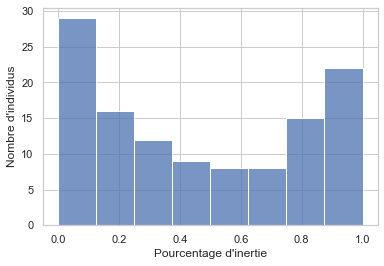

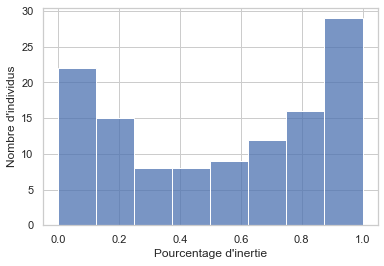

In [48]:
sns.histplot(x='COS2_1',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()
sns.histplot(x='COS2_2',data=data_cos)
plt.ylabel('Nombre d\'individus')
plt.xlabel('Pourcentage d\'inertie')
plt.show()

In [49]:
all_value[all_value['F1'] > 4]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Barcelona,2014,94,0.789,110,21,102.98,28.44,603,255.1,90.438,1.080319,1.120712,Européen,CL,6.100598,-0.707487
1,1,Barcelona,2015,91,0.763,112,29,113.60,34.03,726,322.1,91.188,1.088858,1.152534,Européen,CL,6.576647,0.370880
2,2,Barcelona,2016,90,0.737,116,37,93.55,31.32,772,317.3,104.188,1.056790,1.046776,Européen,CL,5.496078,0.023641
3,1,Barcelona,2017,93,0.737,99,29,90.49,41.62,1100,336.2,184.875,1.028201,1.054345,Européen,CL,6.206258,0.275594
4,1,Barcelona,2018,87,0.684,90,36,83.28,44.93,1200,358.3,206.938,1.068090,1.097687,Européen,CL,6.770580,1.656341
5,2,Barcelona,2019,82,0.658,86,38,72.01,37.82,931,312.3,163.312,1.043755,1.093993,Européen,CL,5.377214,1.087939
6,3,Barcelona,2020,79,0.632,85,38,83.96,40.93,817,263.1,118.812,1.044828,1.070841,Européen,CL,4.467630,0.555989
7,2,Real Madrid,2014,92,0.789,118,38,95.77,42.61,796,299.0,121.125,1.077788,1.170559,Européen,CL,6.748862,0.945946
8,2,Real Madrid,2015,90,0.737,110,34,90.45,45.23,714,252.2,116.125,1.063459,1.077664,Européen,CL,5.477249,-0.051893
9,1,Real Madrid,2016,93,0.763,106,41,90.87,36.86,820,286.4,145.000,1.060500,1.064631,Européen,CL,5.727079,0.419460


In [50]:
all_value[all_value['F2'] < -1]

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
14,3,Atletico Madrid,2014,78,0.605,67,29,57.05,29.07,356,123.3,74.938,1.057905,1.022749,Européen,CL,2.678582,-1.145687
15,3,Atletico Madrid,2015,88,0.737,63,18,54.93,27.80,418,133.7,83.188,1.056783,1.056347,Européen,CL,3.696411,-1.787580
21,4,Valence CF,2014,77,0.579,70,32,55.06,39.39,230,75.4,43.375,1.008459,1.019909,Européen,CL,1.438254,-1.692280
28,5,Sevilla,2014,76,0.605,71,45,69.53,47.86,166,55.4,32.125,1.000899,0.997443,Européen,EL,0.745204,-1.489016
30,4,Sevilla,2016,72,0.553,69,49,59.09,38.70,273,90.2,40.375,1.032037,0.947323,Européen,CL,0.812286,-1.000571
35,6,Villarreal,2014,60,0.421,48,37,56.77,40.70,132,46.7,28.312,1.003623,0.997468,Européen,EL,-0.249031,-1.235352
36,4,Villarreal,2015,64,0.474,44,35,40.49,41.63,140,42.0,30.625,0.992621,1.007748,Européen,CL,-0.137964,-1.514451
57,8,Malaga,2015,48,0.316,38,35,45.75,45.25,77,20.7,12.938,1.008377,0.989444,Non-Européen,NE,-1.108400,-1.109861
78,6,Getafe,2018,59,0.395,48,35,47.03,44.23,135,33.1,32.938,0.974288,0.944720,Européen,EL,-0.966685,-1.800972
79,8,Getafe,2019,54,0.368,43,37,45.19,43.02,175,33.2,38.000,0.989444,0.983889,Non-Européen,NE,-0.743753,-1.126013


C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


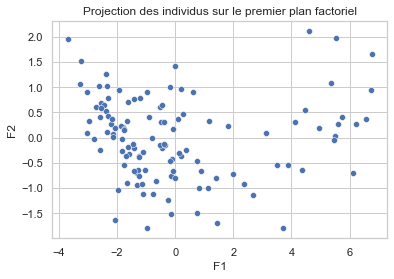

In [51]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['F2'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection des individus sur le premier plan factoriel')
plt.xlabel('F1')
plt.ylabel('F2')
plt.savefig('project1.png')
plt.show()

### Corrélation entre F1 et le classement du club correspondant ? 

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


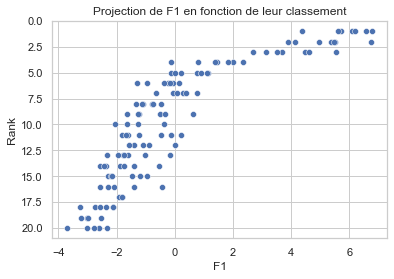

Covariance empirique :  -12.792251869057182
Coefficient de Pearson :  -0.8508443459483319

Les valeurs suivent une distribution linéaire


In [52]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
plt.ylim(21,0)
plt.show()
corré_quant(all_value['F1'],all_value['Rank'])

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


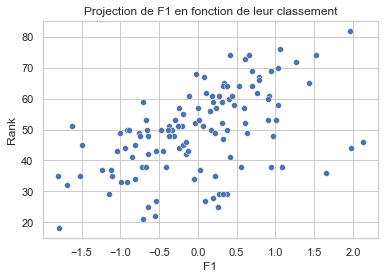

Covariance empirique :  1.667192404914808
Coefficient de Pearson :  0.3624458372070158

Les valeurs suivent une distribution linéaire


In [53]:
figsize = [15,7]
sns.set(style="whitegrid")
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')
plt.savefig('project1.png')
#plt.ylim(21,0)
plt.show()
corré_quant(all_value['F2'],all_value['Rank'])

In [54]:
all_value = all_value[(all_value['GA'] > 40)|(all_value['F2'] < 1)]

C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gormt\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Covariance empirique :  -12.132197822117604
Coefficient de Pearson :  -0.8479173887318578

Les valeurs suivent une distribution linéaire
Covariance empirique :  5.959377847112217
Coefficient de Pearson :  0.5583424749871023

Les valeurs suivent une distribution linéaire


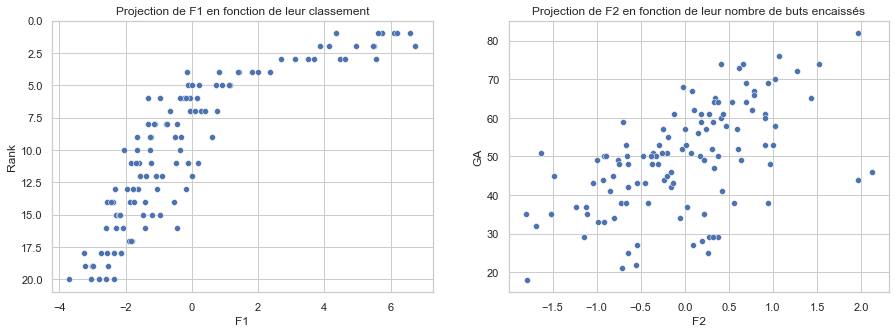

In [55]:
sns.set(style="whitegrid")
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.scatterplot(all_value['F1'],all_value['Rank'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F1 en fonction de leur classement')
plt.xlabel('F1')
plt.ylabel('Rank')

plt.ylim(21,0)
corré_quant(all_value['F1'],all_value['Rank'])
corré_quant(all_value['F2'],all_value['GA'])
plt.subplot(122)
sns.scatterplot(all_value['F2'],all_value['GA'])
# sns.scatterplot(data_compo[data_compo['is_genuine'] == False]['F1'],data_compo[data_compo['is_genuine'] == False]['F2'],c = 'grey')

plt.title('Projection de F2 en fonction de leur nombre de buts encaissés')
plt.xlabel('F2')
plt.ylabel('GA')
#plt.ylim(21,0)
plt.show()

In [56]:
all_value[all_value['is_euro'] == 'Européen']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Barcelona,2014,94,0.789,110,21,102.98,28.44,603,255.1,90.438,1.080319,1.120712,Européen,CL,6.100598,-0.707487
1,1,Barcelona,2015,91,0.763,112,29,113.60,34.03,726,322.1,91.188,1.088858,1.152534,Européen,CL,6.576647,0.370880
2,2,Barcelona,2016,90,0.737,116,37,93.55,31.32,772,317.3,104.188,1.056790,1.046776,Européen,CL,5.496078,0.023641
3,1,Barcelona,2017,93,0.737,99,29,90.49,41.62,1100,336.2,184.875,1.028201,1.054345,Européen,CL,6.206258,0.275594
6,3,Barcelona,2020,79,0.632,85,38,83.96,40.93,817,263.1,118.812,1.044828,1.070841,Européen,CL,4.467630,0.555989
7,2,Real Madrid,2014,92,0.789,118,38,95.77,42.61,796,299.0,121.125,1.077788,1.170559,Européen,CL,6.748862,0.945946
8,2,Real Madrid,2015,90,0.737,110,34,90.45,45.23,714,252.2,116.125,1.063459,1.077664,Européen,CL,5.477249,-0.051893
9,1,Real Madrid,2016,93,0.763,106,41,90.87,36.86,820,286.4,145.000,1.060500,1.064631,Européen,CL,5.727079,0.419460
10,3,Real Madrid,2017,76,0.579,94,44,91.29,45.10,955,299.9,207.062,1.059709,1.091333,Européen,CL,5.546332,1.969460
11,3,Real Madrid,2018,68,0.553,63,46,68.65,48.68,1030,282.1,197.562,1.059577,1.073318,Européen,CL,4.611513,2.122140


Covariance empirique :  604.6166120189154
Coefficient de Pearson :  0.9313054270091128

Les valeurs suivent une distribution linéaire


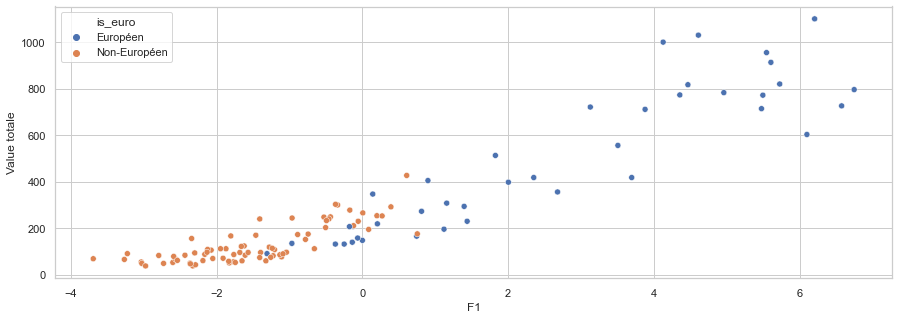

Covariance empirique :  4.433777257411921
Coefficient de Pearson :  0.1684812677312601

Les valeurs suivent une distribution linéaire


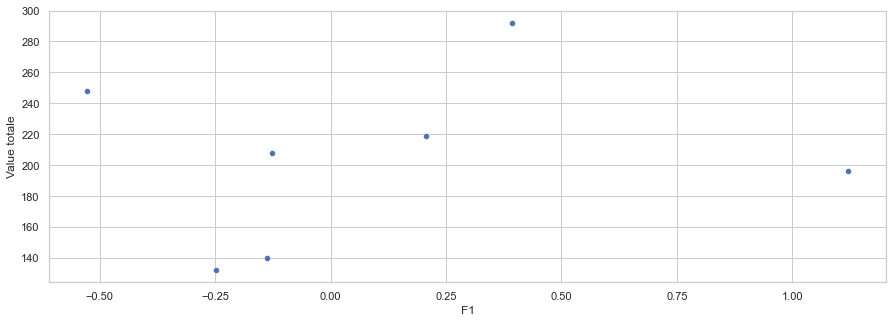

In [58]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['F1'],all_value['Value totale'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='F1',y='Value totale',data=all_value[all_value['Team'] == 'Villarreal'])
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value[all_value['Team'] == 'Villarreal']['F1'],all_value[all_value['Team'] == 'Villarreal']['Value totale'])
plt.show()

In [59]:
all_value.head()

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2
0,1,Barcelona,2014,94,0.789,110,21,102.98,28.44,603,255.1,90.438,1.080319,1.120712,Européen,CL,6.100598,-0.707487
1,1,Barcelona,2015,91,0.763,112,29,113.60,34.03,726,322.1,91.188,1.088858,1.152534,Européen,CL,6.576647,0.370880
2,2,Barcelona,2016,90,0.737,116,37,93.55,31.32,772,317.3,104.188,1.056790,1.046776,Européen,CL,5.496078,0.023641
3,1,Barcelona,2017,93,0.737,99,29,90.49,41.62,1100,336.2,184.875,1.028201,1.054345,Européen,CL,6.206258,0.275594
6,3,Barcelona,2020,79,0.632,85,38,83.96,40.93,817,263.1,118.812,1.044828,1.070841,Européen,CL,4.467630,0.555989


In [60]:
var_F2 = []
for i,a in zip(all_value['Value défense'],all_value['coef défense']):
    var_F2.append((a ** 3))
    print(i,'|',a,'|',(a ** 3))

90.438 | 1.080319090909091 | 1.2608288928351674
91.188 | 1.088858461538461 | 1.2909644741438802
104.188 | 1.05679 | 1.1802284659618387
184.875 | 1.028201176470588 | 1.0870118770495865
118.812 | 1.0448276470588238 | 1.1406015769599727
121.125 | 1.0777878571428572 | 1.2519871140753027
116.125 | 1.0634588235294118 | 1.2027130875358991
145.0 | 1.0605 | 1.192702195125
207.062 | 1.0597088235294116 | 1.1900347719405375
197.562 | 1.059576875 | 1.1895902995048009
170.875 | 1.0674668750000005 | 1.2163630569866146
168.688 | 1.0721053333333337 | 1.2322884258270472
74.938 | 1.0579053333333337 | 1.1839692410678355
83.188 | 1.0567833333333334 | 1.1802061300006623
125.5 | 1.0351731249999998 | 1.109274335553448
140.938 | 1.043842 | 1.1373766325193035
191.188 | 1.0289787499999998 | 1.0894798892802133
157.438 | 1.041328823529412 | 1.1291812781431891
149.188 | 1.048104375 | 1.1513665326923155
43.375 | 1.0084594444444446 | 1.0255936253107174
55.125 | 1.0323568421052634 | 1.1002452984975348
81.562 | 1.03130

Covariance empirique :  604.6166120189154
Coefficient de Pearson :  0.9313054270091128

Les valeurs suivent une distribution linéaire


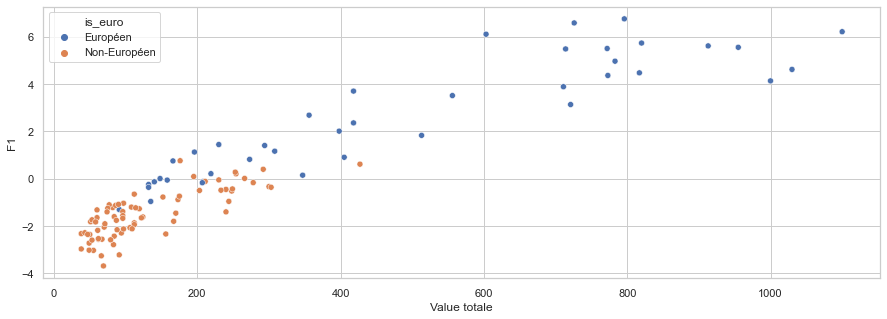

Covariance empirique :  -0.44402608664000204
Coefficient de Pearson :  -0.519404881054689

Les valeurs suivent une distribution linéaire


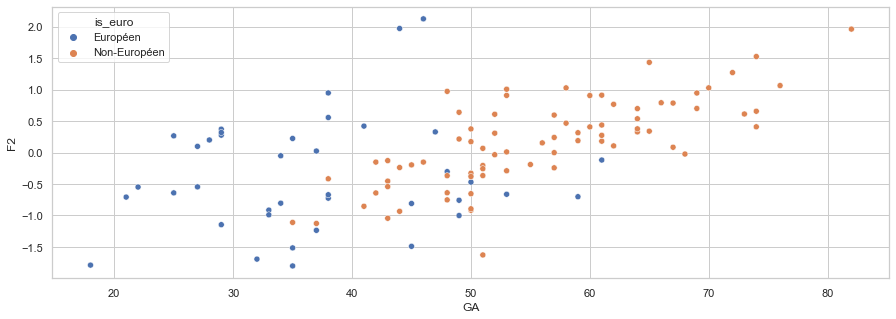

In [61]:
plt.figure(figsize=[15,5])
sns.scatterplot(x='Value totale',y='F1',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()
plt.figure(figsize=[15,5])
sns.scatterplot(x='GA',y='F2',hue='is_euro',data=all_value)
# sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
corré_quant(var_F2,all_value['xGA'])
plt.show()

In [66]:
# Déterminer la fonction de la trend
x = all_value['Value totale']
y_F1= all_value['F1']
y_F2= all_value['F2']
z_F1 = np.polyfit(x,y_F1,1)
z_F2 = np.polyfit(x,y_F2,1)
print ("{0}x + {1}".format(*z_F1))
print ("{0}x + {1}".format(*z_F2))
y_list_F1 = []
y_list_F2 = []
for i in x:
    y_list_F1.append(0.009231867381092976*i + -2.4393319325352447)
    y_list_F2.append(0.00047437744047014425*i + -0.1434647680420678)

0.009231867381092976x + -2.4393319325352447
0.00047437744047014425x + -0.1434647680420678


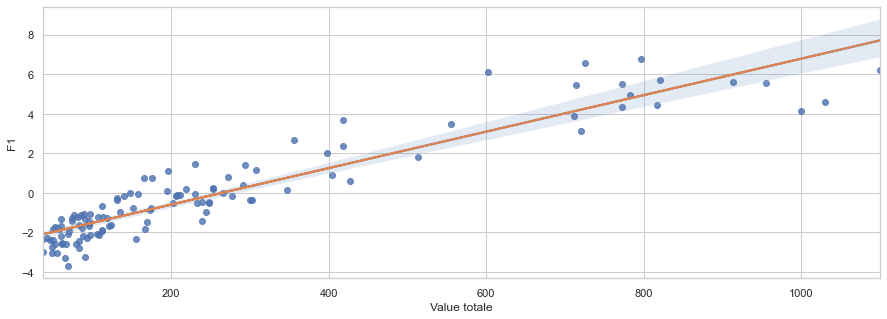

In [67]:
plt.figure(figsize=[15,5])
sns.regplot(x='Value totale',y='F1',data=all_value)
plt.plot(all_value['Value totale'],y_list_F1)
# corré_quant(all_value['Value totale'],all_value['F1'])
plt.show()

La fonction que nous avons obtenue est correcte puisque la trend du regplot et la fonction se superposent

In [68]:
all_value['trend'] = y_list_F1

In [69]:
all_value[all_value['Team'] == 'Villarreal']

,Rank,Team,Years,PTS,win_rate,G,GA,xG,xGA,Value totale,Value attaque,Value défense,coef défense,coef attaque,is_euro,is_euro_detail,F1,F2,trend
35,6,Villarreal,2014,60,0.421,48,37,56.77,40.70,132,46.7,28.312,1.003623,0.997468,Européen,EL,-0.249031,-1.235352,-1.220725
36,4,Villarreal,2015,64,0.474,44,35,40.49,41.63,140,42.0,30.625,0.992621,1.007748,Européen,CL,-0.137964,-1.514451,-1.146870
37,5,Villarreal,2016,67,0.500,56,33,52.23,43.16,196,57.1,46.812,1.018705,1.064587,Européen,EL,1.120730,-0.989343,-0.629886
38,5,Villarreal,2017,61,0.474,57,50,55.67,54.24,219,65.3,38.312,1.008892,1.019157,Européen,EL,0.206834,-0.371632,-0.417553
39,14,Villarreal,2018,44,0.263,49,52,54.80,56.12,248,78.7,50.688,1.022064,1.002803,Non-Européen,NE,-0.527182,0.607556,-0.149829
40,5,Villarreal,2019,60,0.474,63,49,65.61,48.59,208,85.6,33.625,0.989165,0.980065,Européen,EL,-0.127172,-0.757724,-0.519104
41,7,Villarreal,2020,58,0.395,60,44,57.86,43.67,292,109.6,74.250,0.992375,1.004117,Non-Européen,NE,0.392308,-0.238452,0.256373


In [70]:
# plt.figure(figsize=[20,5])
# plt.subplot(121)
# list_trend = list(abs(all_value[all_value['Team'] == 'Arsenal']['trend']*10))
# list_value = list(abs(all_value[all_value['Team'] == 'Arsenal']['Value totale']/10))
# sns.lineplot(x='Years',y='Rank',data=all_value[all_value['Team'] == 'Arsenal'],label='Rank')
# sns.lineplot(x='Years',y=list_trend,data=all_value[all_value['Team'] == 'Arsenal'],label='trend')
# # sns.lineplot(x='Years',y='Valeur marchande (millions)',data=total,label='Valeurs marchande moyenne')
# plt.ylim(21,0)
# plt.subplot(122)

# sns.lineplot(x='Years',y='Value totale',data=all_value[all_value['Team'] == 'Arsenal'],label='Valeur totale')
# plt.show()

A partir des corrélations, on va va prévoir se baser sur 3 variables pour prévoir le futur classement du mhsc :
* Classement
* F1
* Valeur de l'effectif

In [71]:
all_value.columns

Index(['Rank', 'Team', 'Years', 'PTS', 'win_rate', 'G', 'GA', 'xG', 'xGA',
       'Value totale', 'Value attaque', 'Value défense', 'coef défense',
       'coef attaque', 'is_euro', 'is_euro_detail', 'F1', 'F2', 'trend'],
      dtype='object')

In [72]:
variables = all_value[['Team','Rank','F1','Value totale','Years','is_euro','is_euro_detail','trend','win_rate']]

In [73]:
list_value = []
for i in variables['Value totale']:
    if i < 100:
        list_value.append('> 100 m')
    elif (i >= 100)&(i < 200): 
        list_value.append('100 m < i < 200 m')
    elif (i >= 200)&(i < 300): 
        list_value.append('200 m < i < 300 m')
    elif (i >= 300)&(i < 450): 
        list_value.append('300 m < i < 450 m')
    elif (i >= 450)&(i < 650): 
        list_value.append('450 m < i < 650 m')
    elif (i >= 650)&(i < 800): 
        list_value.append('650 m < i < 800 m')
    elif i >= 800: 
        list_value.append('> 800 m')
variables['ech_value'] = list_value

<ipython-input-73-135024b17614>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['ech_value'] = list_value


In [74]:
pal = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)


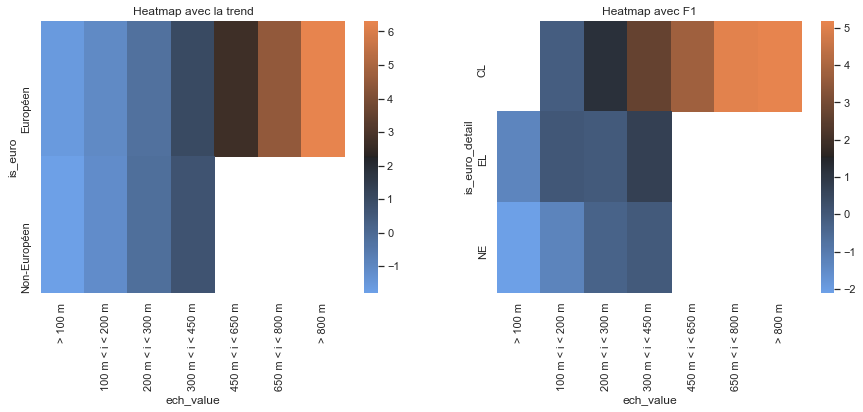

In [75]:
euro_var = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','trend']].pivot(index='is_euro',columns='ech_value',values='trend')[['> 100 m','100 m < i < 200 m','200 m < i < 300 m','300 m < i < 450 m','450 m < i < 650 m','650 m < i < 800 m','> 800 m']]
euro_detail_var = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','trend']].pivot(index='is_euro_detail',columns='ech_value',values='trend')[['> 100 m','100 m < i < 200 m','200 m < i < 300 m','300 m < i < 450 m','450 m < i < 650 m','650 m < i < 800 m','> 800 m']]
euro_var_F1 = variables.groupby(['is_euro','ech_value']).mean().reset_index()[['is_euro','ech_value','F1']].pivot(index='is_euro',columns='ech_value',values='F1')[['> 100 m','100 m < i < 200 m','200 m < i < 300 m','300 m < i < 450 m','450 m < i < 650 m','650 m < i < 800 m','> 800 m']]
euro_detail_var_F1 = variables.groupby(['is_euro_detail','ech_value']).mean().reset_index()[['is_euro_detail','ech_value','F1']].pivot(index='is_euro_detail',columns='ech_value',values='F1')[['> 100 m','100 m < i < 200 m','200 m < i < 300 m','300 m < i < 450 m','450 m < i < 650 m','650 m < i < 800 m','> 800 m']]
plt.figure(figsize=[15,5])
plt.subplot(121)
sns.heatmap(euro_var,cmap=pal)
plt.title('Heatmap avec la trend')
plt.subplot(122)
sns.heatmap(euro_detail_var_F1,cmap=pal)
plt.title('Heatmap avec F1')
plt.show()
# plt.figure(figsize=[15,5])
# plt.subplot(121)
# sns.heatmap(euro_detail_var,cmap=pal)
# plt.title('Heatmap avec la trend')
# plt.subplot(122)
# sns.heatmap(euro_detail_var_F1,cmap=pal)
# plt.title('Heatmap avec F1')
# plt.show()

### Prédictions 

Régression logistique

K-Means

In [76]:
# <!-- * analyse de la variance -->

In [77]:
variables.head()

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value
0,Barcelona,1,6.100598,603,2014,Européen,CL,3.127484,0.789,450 m < i < 650 m
1,Barcelona,1,6.576647,726,2015,Européen,CL,4.263004,0.763,650 m < i < 800 m
2,Barcelona,2,5.496078,772,2016,Européen,CL,4.687670,0.737,650 m < i < 800 m
3,Barcelona,1,6.206258,1100,2017,Européen,CL,7.715722,0.737,> 800 m
6,Barcelona,3,4.467630,817,2020,Européen,CL,5.103104,0.632,> 800 m


#### K-Means 

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


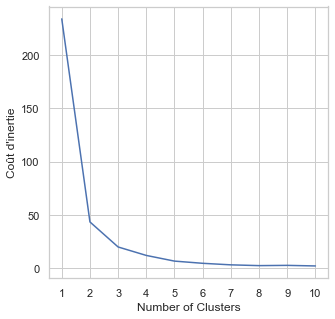

In [78]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition,preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

data = variables[["trend","Value totale"]]
X = data.values
X_scaled = preprocessing.StandardScaler().fit_transform(X)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    
fig_1 = plt.figure(figsize=(5,5))

#plt.style.use("fivethirtyeight")
sns.set(style="whitegrid")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Coût d'inertie")
plt.savefig('graph_cout_inert.png')
plt.show()

In [79]:
# Projection des individus
# Réduire  ici est nécessaire car les variables sont pas exprimées dans la même unité
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#X_projected = pca.transform(X_scaled)

# Clustering par K-means
# 2 clusters
km = KMeans(n_clusters=2)
km.fit(X_scaled)
y_means = km.predict(X_scaled)

km3 = KMeans(n_clusters=3)
km3.fit(X_scaled)
y_means3 = km3.predict(X_scaled)

clust_lab3 = km3.labels_

ValueError: 'c' argument has 117 elements, which is inconsistent with 'x' and 'y' with size 119.

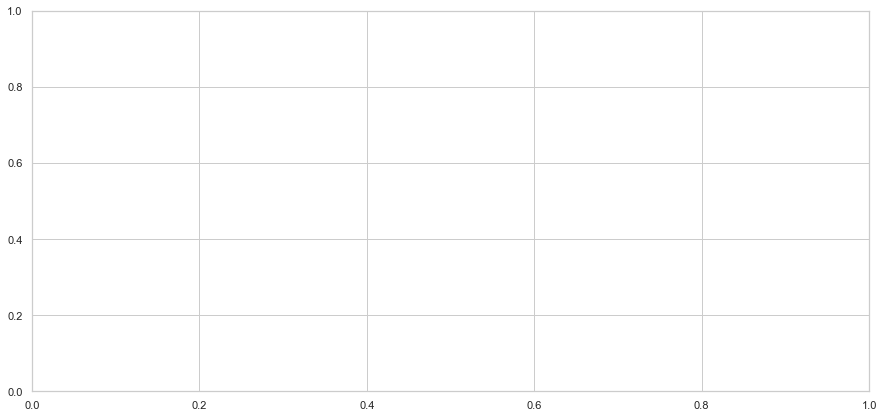

In [80]:
import matplotlib.patches as mpatches
# Visualisation de nos deux clusters dans le premier plan factoriel

plt.figure(figsize=(15, 7))

categories = km.labels_
colormap = np.array(['royalblue','coral'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

plt.figure(figsize=(15, 7))
categories3 = km3.labels_
colormap = np.array(['royalblue','coral','grey'])
sns.set(style="whitegrid")
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories3], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='royalblue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='coral', alpha=0.5, label='1')
lab_2 = mpatches.Patch(color='grey', alpha=0.5, label='2')
plt.legend(handles=[lab_0, lab_1, lab_2])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)),fontsize='large')
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)),fontsize='large')
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.savefig('project_ind_kmeans.png')
plt.show()

In [81]:
variables['clusters'] = categories
# variables['clusters_3'] = categories3

<ipython-input-81-10f62482c47d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables['clusters'] = categories


In [82]:
variables

,Team,Rank,F1,Value totale,Years,is_euro,is_euro_detail,trend,win_rate,ech_value,clusters
0,Barcelona,1,6.100598,603,2014,Européen,CL,3.127484,0.789,450 m < i < 650 m,0
1,Barcelona,1,6.576647,726,2015,Européen,CL,4.263004,0.763,650 m < i < 800 m,0
2,Barcelona,2,5.496078,772,2016,Européen,CL,4.687670,0.737,650 m < i < 800 m,0
3,Barcelona,1,6.206258,1100,2017,Européen,CL,7.715722,0.737,> 800 m,0
6,Barcelona,3,4.467630,817,2020,Européen,CL,5.103104,0.632,> 800 m,0
...,...,...,...,...,...,...,...,...,...,...,...
114,Leganes,18,-2.123411,109,2019,Non-Européen,NE,-1.433058,0.211,100 m < i < 200 m,1
115,Osasuna,11,-1.680758,96,2020,Non-Européen,NE,-1.553073,0.289,> 100 m,1
116,Girona,18,-2.130813,97,2018,Non-Européen,NE,-1.543841,0.237,> 100 m,1
117,Real Valladolid,13,-1.763449,87,2019,Non-Européen,NE,-1.636159,0.237,> 100 m,1


<AxesSubplot:xlabel='clusters', ylabel='is_euro'>

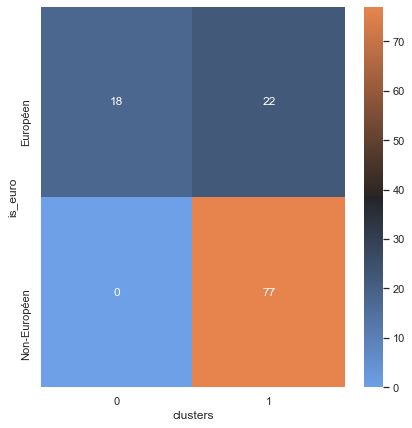

In [83]:
euro = pd.crosstab(variables['is_euro'], variables["clusters"],margins=True,margins_name='Total')
# euro_bis = pd.crosstab(variables['is_euro_detail'], variables["clusters_3"],margins=True,margins_name='Total')
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.heatmap(euro.iloc[0:2,0:-1],annot=True, cmap=pal)
# plt.subplot(122)
# sns.heatmap(euro_bis.iloc[0:3,0:-1],annot=True, cmap=pal)
# plt.show()

Résultat beaucoup trop approximatif pour le second K-Means

Cependant, on peut poursuivre l'analyse avec le premier K-Means dont les résultats sont pas si mauvais, seulement 5 faux-négatifs et faux-positifs

In [85]:
from sklearn.model_selection import train_test_split
variables_corr = variables[['Team','Rank','trend','Value totale','Years','is_euro','ech_value','clusters','win_rate']]
list_euro = []
for i in variables_corr['is_euro']:
    if i == 'Européen':
        list_euro.append(1)
    elif i == 'Non-Européen':
        list_euro.append(0)
variables_corr['is_euro'] = list_euro 
xtrain, xtest, ytrain, ytest = train_test_split(variables_corr[['trend']], variables_corr[['is_euro']], train_size=0.8)

<ipython-input-85-be139310768c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_corr['is_euro'] = list_euro


In [86]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import pickle

modele_logit = LogisticRegression()
modele_logit.fit(xtrain,ytrain)
precision = modele_logit.score(xtest,ytest)

with open('model_mhsc.pkl', 'wb') as f:
    my_pickler = pickle.Pickler(f)
    my_pickler.dump(modele_logit)

C:\Users\gormt\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


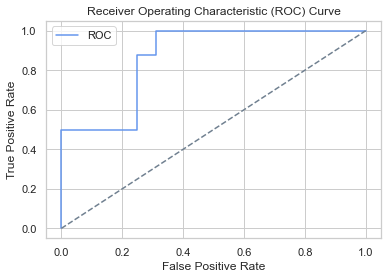

In [87]:
probs = modele_logit.predict_proba(xtest)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(ytest, probs) 
plot_roc_curve(fper, tper)

#### Matrice de confusion

In [88]:
variables_corr = variables_corr.reset_index()
ytest = ytest.reset_index()

In [89]:
variables_corr

,index,Team,Rank,trend,Value totale,Years,is_euro,ech_value,clusters,win_rate
0,0,Barcelona,1,3.127484,603,2014,1,450 m < i < 650 m,0,0.789
1,1,Barcelona,1,4.263004,726,2015,1,650 m < i < 800 m,0,0.763
2,2,Barcelona,2,4.687670,772,2016,1,650 m < i < 800 m,0,0.737
3,3,Barcelona,1,7.715722,1100,2017,1,> 800 m,0,0.737
4,6,Barcelona,3,5.103104,817,2020,1,> 800 m,0,0.632
...,...,...,...,...,...,...,...,...,...,...
112,114,Leganes,18,-1.433058,109,2019,0,100 m < i < 200 m,1,0.211
113,115,Osasuna,11,-1.553073,96,2020,0,> 100 m,1,0.289
114,116,Girona,18,-1.543841,97,2018,0,> 100 m,1,0.237
115,117,Real Valladolid,13,-1.636159,87,2019,0,> 100 m,1,0.237


In [90]:
data_predict = pd.merge(variables_corr,ytest,how = 'inner',on='index')
data_predict = data_predict.drop(['index'],axis=1)

In [91]:
data_predict

,Team,Rank,trend,Value totale,Years,is_euro_x,ech_value,clusters,win_rate,is_euro_y
0,Real Madrid,2,4.909235,796,2014,1,650 m < i < 800 m,0,0.789,1
1,Real Madrid,1,5.130799,820,2016,1,> 800 m,0,0.763,1
2,Real Madrid,1,5.989363,913,2019,1,> 800 m,0,0.684,1
3,Atletico Madrid,2,4.124526,711,2017,1,650 m < i < 800 m,0,0.605,1
4,Sevilla,7,-0.316002,230,2015,0,200 m < i < 300 m,1,0.368,0
5,Villarreal,5,-0.417553,219,2017,1,200 m < i < 300 m,1,0.474,1
6,Villarreal,14,-0.149829,248,2018,0,200 m < i < 300 m,1,0.263,0
7,Villarreal,5,-0.519104,208,2019,1,200 m < i < 300 m,1,0.474,1
8,Athletic Bilbao,16,-0.140597,249,2017,0,200 m < i < 300 m,1,0.263,0
9,Celta Vigo,8,-1.036088,152,2020,0,100 m < i < 200 m,1,0.368,0


In [92]:
predict = pd.crosstab(data_predict['is_euro_x'], data_predict["is_euro_y"],rownames=['Actual'], colnames=['Predicted'],margins=True,margins_name='Total')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

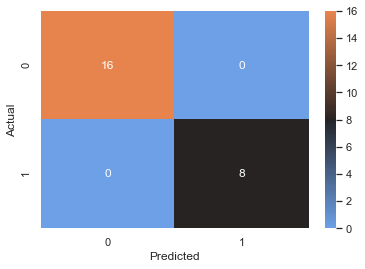

In [93]:
sns.heatmap(predict.iloc[0:2,0:-1],annot=True, cmap=pal)

In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(' ')
print('Precision: %.3f' % precision_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Recall: %.3f' % recall_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('Accuracy: %.3f' % accuracy_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))
print('F1 Score: %.3f' % f1_score(data_predict['is_euro_x'], data_predict["is_euro_y"]))

 
Precision: 1.000
Recall: 1.000
Accuracy: 1.000
F1 Score: 1.000


In [95]:
print(sklearn.metrics.classification_report(data_predict['is_euro_x'], data_predict["is_euro_y"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [96]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import Logit
mode = Logit(endog=ytrain,exog=xtrain)
lr = mode.fit()

lr.summary()

Optimization terminated successfully.
         Current function value: 0.355916
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_euro   No. Observations:                   93
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            0
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                  0.4471
Time:                        19:26:01   Log-Likelihood:                -33.100
converged:                       True   LL-Null:                       -59.865
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.4068      0.272      5.176      0.000       0.874       1.939
==============================================================================
"""